In [1]:
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch
from PIL import Image
from matplotlib.pyplot import figure, title
from torch.utils.data import DataLoader
import tqdm
import math
import einops
import random, os
import numpy as np
from torchvision.utils import make_grid
from scipy.io import loadmat
from torchvision import datasets, transforms
from scipy.io import loadmat
from torch.utils.data import Dataset
from torch import nn
import torch
from torch.utils.data import DataLoader
import random
import torchvision.utils as vutils
import matplotlib.pyplot as plt

In [2]:
batch_size = 64
num_workers = 8

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
set_seed(42)

In [4]:
mnist = loadmat("../mnist-original.mat/mnist-original.mat")
mnist_data = mnist["data"].T
mnist_label = mnist["label"][0]

In [5]:
from torchvision import transforms
transform = transforms.Compose([
    transforms.Lambda(lambda x: x.reshape(28, 28)),
    transforms.ToTensor(),
    transforms.Pad((2, 2, 2, 2))  # Pad to 32x32
])

In [6]:
class MNISTDataset(Dataset):
    def __init__(self, data, label, transform=None):
        self.data = data
        self.label = label
        self.transform = transform
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.transform(self.data[idx]), self.label[idx]

In [7]:
from torch.utils.data import random_split

# Assuming mnist_data and mnist_label are already defined
dataset = MNISTDataset(mnist_data, mnist_label, transform=transform)

# Define the lengths for training and validation sets
train_size = 60000
val_size = 10000

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Now you can use train_dataset and val_dataset with DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)


In [8]:
def show_images(images,title=''):
    grid = vutils.make_grid(images, nrow=4, padding=2, normalize=True)
    plt.figure(figsize=(8,8))
    plt.title(title)
    plt.imshow(grid.permute(1, 2, 0).cpu(), cmap='gray')  # 调整维度顺序
    plt.axis('off')
    plt.show()
    plt.close()

In [9]:
class DDPM(nn.Module):
    def __init__(
        self,
        T: int,
        eps_model: nn.Module,
        device: str
    ):
        super().__init__()
        self.T = T
        self.eps_model = eps_model.to(device)
        self.device = device
        beta_schedule = torch.linspace(1e-4, 0.02, T + 1, device=device)
        alpha_t_schedule = 1 - beta_schedule
        bar_alpha_t_schedule = torch.cumprod(alpha_t_schedule.detach().cpu(), 0).to(device)
        sqrt_bar_alpha_t_schedule = torch.sqrt(bar_alpha_t_schedule)
        sqrt_minus_bar_alpha_t_schedule = torch.sqrt(1 - bar_alpha_t_schedule)
        self.register_buffer("beta_schedule", beta_schedule)
        self.register_buffer("alpha_t_schedule", alpha_t_schedule)
        self.register_buffer("bar_alpha_t_schedule", bar_alpha_t_schedule)
        self.register_buffer("sqrt_bar_alpha_t_schedule", sqrt_bar_alpha_t_schedule)
        self.register_buffer("sqrt_minus_bar_alpha_t_schedule", sqrt_minus_bar_alpha_t_schedule)
        self.criterion = nn.MSELoss()

    def forward(self, imgs):
        # random choose some time steps
        t = torch.randint(low=1, high=self.T+1, size=(imgs.shape[0],), device=self.device)

        # get random noise to add it to the images
        noise = torch.randn_like(imgs, device=self.device)

        # get noise image as: sqrt(alpha_t_bar) * x0 + noise * sqrt(1 - alpha_t_bar)
        batch_size, channels, width, height = imgs.shape
        noise_imgs = self.sqrt_bar_alpha_t_schedule[t].view((batch_size, 1, 1 ,1)) * imgs \
            + self.sqrt_minus_bar_alpha_t_schedule[t].view((batch_size, 1, 1, 1)) * noise
        
        # get predicted noise from our model
        pred_noise = self.eps_model(noise_imgs, t.unsqueeze(1))

        # calculate of Loss simple ||noise - pred_noise||^2, which is MSELoss
        return self.criterion(pred_noise, noise)
    
    def sample(self, n_samples, size):
        self.eval()
        with torch.no_grad():
            # get normal noise
            x_t = torch.randn(n_samples, *size, device=self.device)
            # calculate x_(t-1) on every iteration
            for t in range(self.T, 0, -1):
                t_tensor = torch.tensor([t], device=self.device).repeat(x_t.shape[0], 1)
                # get predicted noise from model
                pred_noise = self.eps_model(x_t, t_tensor)

                # get some noise to calculate x_(t-1) as in formula (How to get a Noise)
                # for t = 0, noise should be 0
                z = torch.randn_like(x_t, device=self.device) if t > 0 else 0

                # Formula from How to get sample
                # x_(t-1) = 1 / sqrt(alpha_t) * (x_t - pred_noise * (1 - alpha_t) / sqrt(1 - alpha_t_bar)) + beta_t * eps
                x_t = 1 / torch.sqrt(self.alpha_t_schedule[t]) * \
                    (x_t - pred_noise * (1 - self.alpha_t_schedule[t]) / self.sqrt_minus_bar_alpha_t_schedule[t]) + \
                    torch.sqrt(self.beta_schedule[t]) * z
            return x_t

In [10]:
def train(
    model: DDPM,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: str,
    train_dataloader: DataLoader,
    val_dataloader: DataLoader
):
    training_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for index, (imgs, labels) in enumerate(val_dataloader):
                imgs = imgs.to(device)
                
                loss = model(imgs)
        
                val_loss += loss.item()
                if index == 0 and epoch % 10 == 0:
                    x_t = model.sample(n_samples=16, size=imgs[0].shape)
                    show_images(x_t, title=f'epoch {epoch}')
        model.train(True)
        training_loss = 0
        pbar = tqdm.tqdm(train_dataloader)
        for index, (imgs, labels) in enumerate(pbar):
            optimizer.zero_grad()
            
            imgs = imgs.to(device)
    
            loss = model(imgs)
    
            loss.backward()
            optimizer.step()
            training_loss += loss.item()
            pbar.set_description(f"loss for epoch {epoch}: {training_loss / (index + 1):.4f}")

        training_losses.append(training_loss / len(val_dataloader))
        val_losses.append(val_loss / len(val_dataloader))
    return training_losses, val_losses


In [11]:

class MLP(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super().__init__()
        self.ln = nn.Sequential(
            nn.ReLU(),
            nn.Linear(input_dim, output_dim),
        )

    def forward(self, x):
        return self.ln(x)
    
class PositionalEmbedding(nn.Module):
    def __init__(self, T: int, output_dim: int) -> None:
        super().__init__()
        self.output_dim = output_dim
        position = torch.arange(T).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, output_dim, 2) * (-math.log(10000.0) / output_dim))
        pe = torch.zeros(T, output_dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor):
        return self.pe[x].reshape(x.shape[0], self.output_dim)
    
class MultiheadAttention(nn.Module):
    def __init__(self, n_heads: int, emb_dim: int, input_dim: int) -> None:
        super().__init__()
        assert emb_dim % n_heads == 0
        head_dim = emb_dim // n_heads
        self.K_W = nn.Parameter(torch.rand(n_heads, input_dim, head_dim))
        self.K_b = nn.Parameter(torch.rand(n_heads, head_dim))
        self.Q_W = nn.Parameter(torch.rand(n_heads, input_dim, head_dim))
        self.Q_b = nn.Parameter(torch.rand(n_heads, head_dim))
        self.V_W = nn.Parameter(torch.rand(n_heads, input_dim, head_dim))
        self.V_b = nn.Parameter(torch.rand(n_heads, head_dim))
        self.O_W = nn.Parameter(torch.rand(n_heads, head_dim, input_dim))
        self.O_b = nn.Parameter(torch.rand(input_dim))
        self.norm = nn.LayerNorm([input_dim])
        self.mlp = nn.Sequential(
            nn.LayerNorm([input_dim]),
            nn.Linear(input_dim, input_dim),
            nn.GELU(),
            nn.Linear(input_dim, input_dim)
        )

    def forward(self, x, t):
        _, input_dim, h, w = x.shape
        x = einops.rearrange(x, "b c h w -> b (h w) c")
        res = x
        res = self.norm(x)
        k = einops.einsum(res, self.K_W, "b size ch, n_h ch h_dim -> b size n_h h_dim")
        k = k + self.K_b
        q = einops.einsum(res, self.Q_W, "b size ch, n_h ch h_dim -> b size n_h h_dim")
        q = q + self.Q_b
        qk = einops.einsum(q, k, "batch s1 n_h h_dim, batch s2 n_h h_dim -> batch n_h s1 s2")
        qk = qk / torch.sqrt(torch.tensor(input_dim, dtype=torch.float))
        qk = qk.softmax(-1)
        v = einops.einsum(res, self.V_W, "b size ch, n_h ch h_dim -> b size n_h h_dim")
        v = v + self.V_b
        res = einops.einsum(qk, v, "batch n_h size size, batch size n_h h_dim -> batch size n_h h_dim")
        res = einops.einsum(res, self.O_W, "batch size n_h h_dim, n_h h_dim ch -> batch size ch")
        res = res + self.O_b
        res = res + x
        res = self.mlp(res) + res
        res = einops.rearrange(res, "b (h w) c -> b c h w", h=h, w=w)
        return res

class ResnetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim, is_residual=False, is_debug=False):
        super().__init__()
        self.conv_1 = nn.Sequential(
            nn.GroupNorm(8, in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1),
        )
        self.conv_2 = nn.Sequential(
            nn.GroupNorm(8, out_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1)
        )
        self.time_emb = MLP(input_dim=time_emb_dim, output_dim=out_channels)
        if in_channels != out_channels:
            self.conv_3 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1)
        else:
            self.conv_3 = nn.Identity()
        self.is_debug = is_debug
        self.is_residual = is_residual

    def forward(self, x, t):
        h = self.conv_1(x)
        if t is None:
            return self.conv_3(x) + self.conv_2(h)
        t = self.time_emb(t)
        batch_size, emb_dim = t.shape 
        t = t.view(batch_size, emb_dim, 1, 1)
        if self.is_residual:
            return self.conv_3(x) + self.conv_2(h + t)
        else:
            return self.conv_2(h + t)
        

class DownBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.AvgPool2d(kernel_size=2)
    
    def forward(self, x, t):
        return self.pool(x)
    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upscale = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=2, stride=2)
    
    def forward(self, x, t):
        return self.upscale(x)

class SequenceWithTimeEmbedding(nn.Module):
    def __init__(self, blocks):
        super().__init__()
        self.models = nn.ModuleList(blocks)
    
    def forward(self, x, t):
        for model in self.models:
            x = model(x, t)
        return x

In [12]:

class UNet(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            T,
            steps=(1, 2, 4),
            hid_size = 128,
            attn_step_indexes = [1],
            has_residuals=True,
            num_resolution_blocks=2,
            is_debug = False
        ):
        super().__init__()

        time_emb_dim = hid_size * 4
        self.time_embedding = nn.Sequential(
            PositionalEmbedding(T=T, output_dim=hid_size),
            nn.Linear(hid_size, time_emb_dim),
            nn.ReLU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )

        self.first_conv = nn.Conv2d(in_channels, steps[0] * hid_size, 3, padding=1)
        self.down_blocks = nn.ModuleList()
        prev_hid_size = steps[0] * hid_size
        for (index, step) in enumerate(steps):
            res_blocks = []
            for block in range(num_resolution_blocks):
                res_blocks.append(
                    ResnetBlock(
                        in_channels=prev_hid_size if block == 0 else step * hid_size,
                        out_channels=step * hid_size,
                        time_emb_dim=time_emb_dim,
                        is_residual=has_residuals
                    )
                )
                if step in attn_step_indexes:
                    res_blocks.append(
                        MultiheadAttention(
                            n_heads=4,
                            emb_dim=step * hid_size,
                            input_dim=step * hid_size
                        )
                    )
            self.down_blocks.append(
                SequenceWithTimeEmbedding(res_blocks)
            )
            if index != len(steps) - 1:
                self.down_blocks.append(DownBlock())
            prev_hid_size = step * hid_size
        if len(attn_step_indexes) > 0:
            self.backbone = SequenceWithTimeEmbedding([
                ResnetBlock(steps[-1] * hid_size, steps[-1] * hid_size, time_emb_dim=time_emb_dim),
                MultiheadAttention(n_heads=4, emb_dim=steps[-1] * hid_size, input_dim=steps[-1] * hid_size),
                ResnetBlock(steps[-1] * hid_size, steps[-1] * hid_size, time_emb_dim=time_emb_dim),
            ])
        else:
            self.backbone = SequenceWithTimeEmbedding([
                ResnetBlock(steps[-1] * hid_size, steps[-1] * hid_size, time_emb_dim=time_emb_dim),
                ResnetBlock(steps[-1] * hid_size, steps[-1] * hid_size, time_emb_dim=time_emb_dim),
            ])

        self.up_blocks = nn.ModuleList()
        reverse_steps = list(reversed(steps))
        for (index, step) in enumerate(reverse_steps):
            res_blocks = []
            for block in range(num_resolution_blocks):
                next_hid_size = reverse_steps[index + 1] * hid_size if index != len(steps) - 1 else step * hid_size
                res_blocks.append(
                    ResnetBlock(
                        in_channels=prev_hid_size * 2 if block == 0 else next_hid_size,
                        out_channels=next_hid_size,
                        time_emb_dim=time_emb_dim,
                        is_residual=has_residuals
                    )
                )
                if len(reverse_steps) - index - 1 in attn_step_indexes:
                    res_blocks.append(
                        MultiheadAttention(
                            n_heads=4,
                            emb_dim=next_hid_size,
                            input_dim=next_hid_size
                        )
                    )
            self.up_blocks.append(
                SequenceWithTimeEmbedding(res_blocks)
            )
            if index != len(steps) - 1:
                self.up_blocks.append(UpBlock(next_hid_size, next_hid_size))
            prev_hid_size = next_hid_size

        self.is_debug = is_debug
        self.out = nn.Sequential(*[
            nn.GroupNorm(8, steps[0] * hid_size),
            nn.ReLU(),
            nn.Conv2d(in_channels=steps[0] * hid_size, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        ])

    def forward(self, x, t):
        time_emb = self.time_embedding(t)

        x = self.first_conv(x)
        hx = []
        for down_block in self.down_blocks:
            x = down_block(x, time_emb)
            if not isinstance(down_block, DownBlock):
                hx.append(x)
        x = self.backbone(x, time_emb)

        ind = len(hx) - 1
        for up_block in self.up_blocks:
            if not isinstance(up_block, UpBlock):
                x = up_block(torch.cat([x, hx[ind]], 1), time_emb)
                ind -= 1
            else:
                x = up_block(x, time_emb)
        x = self.out(x)

        return x

In [13]:
T = 1000
EPOCHS = 80
device = "cuda" if torch.cuda.is_available() else "cpu"

ddpm = DDPM(
    T = T,
    eps_model=UNet(
        in_channels=1,
        out_channels=1,
        T=T+1,
        steps=(1,2,2,2),
        attn_step_indexes=[1,2]
    ),
    device=device
)

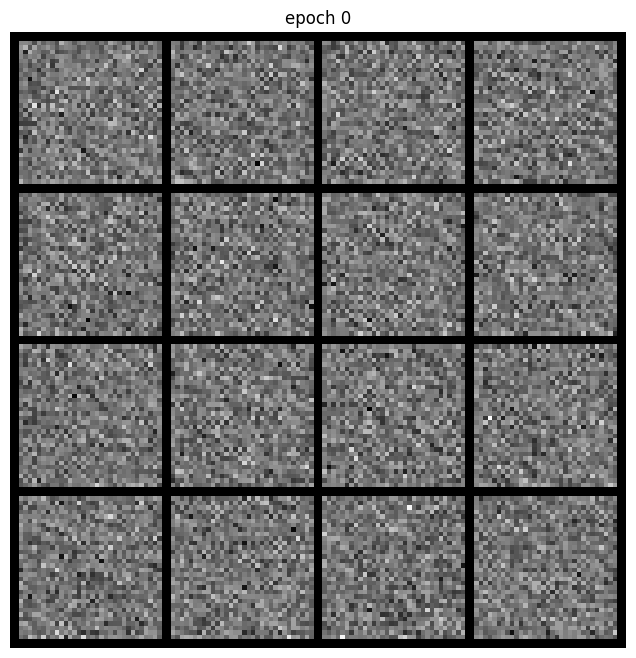

loss for epoch 0: 0.0452: 100%|██████████| 938/938 [02:47<00:00,  5.59it/s]


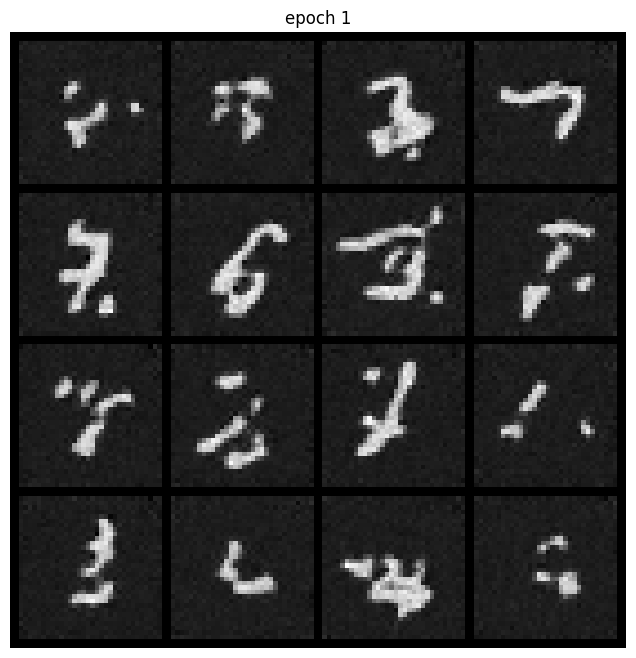

loss for epoch 1: 0.0200: 100%|██████████| 938/938 [02:49<00:00,  5.55it/s]


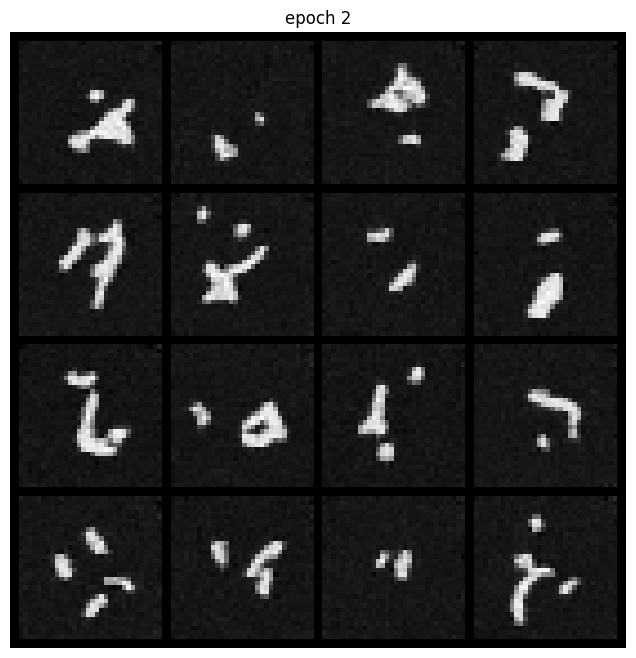

loss for epoch 2: 0.0174: 100%|██████████| 938/938 [02:50<00:00,  5.52it/s]


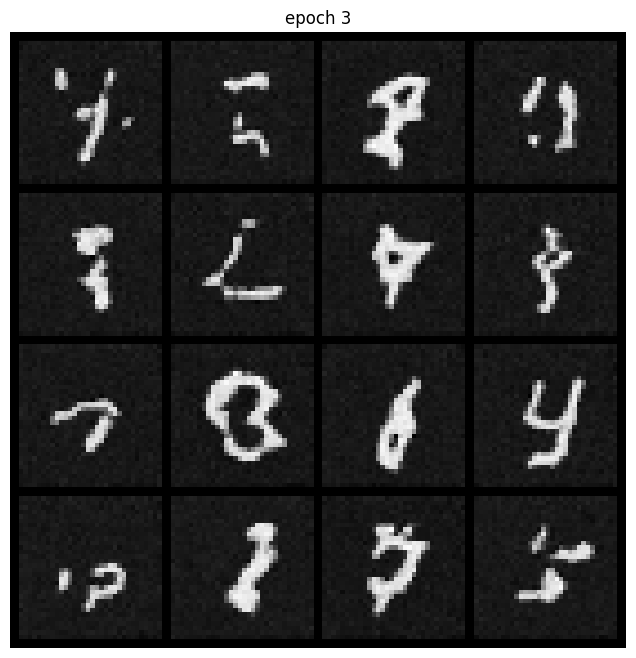

loss for epoch 3: 0.0160: 100%|██████████| 938/938 [02:50<00:00,  5.51it/s]


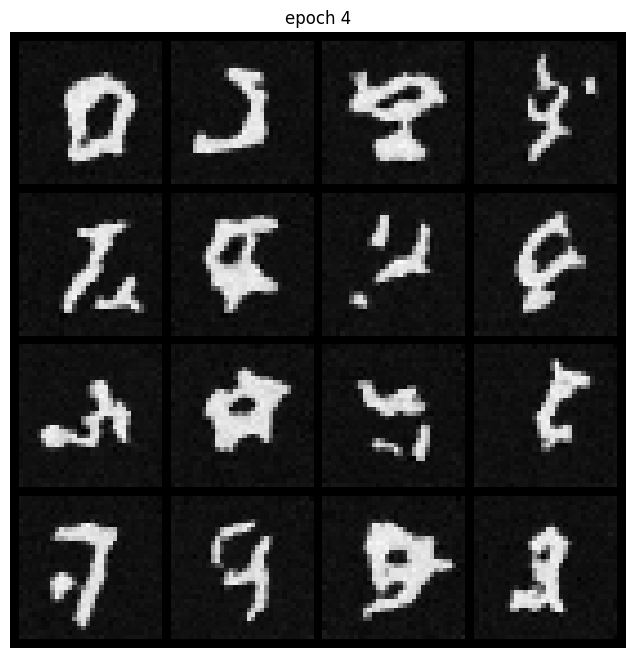

loss for epoch 4: 0.0153: 100%|██████████| 938/938 [02:49<00:00,  5.53it/s]


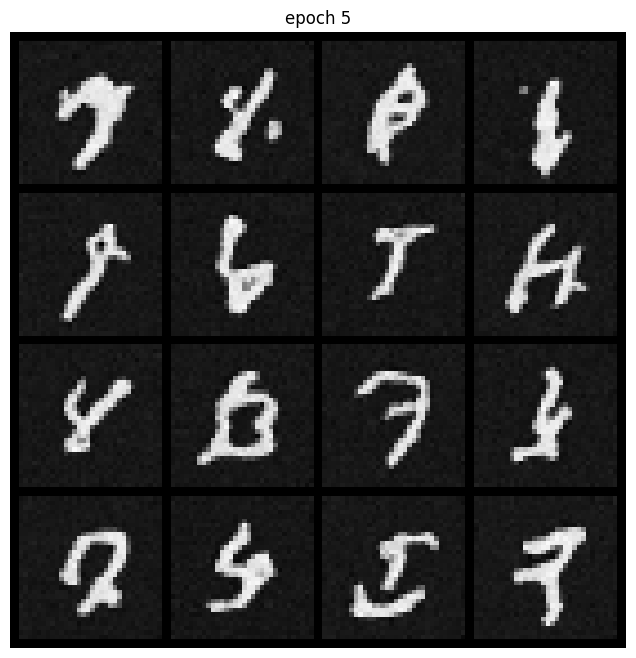

loss for epoch 5: 0.0146: 100%|██████████| 938/938 [02:50<00:00,  5.50it/s]


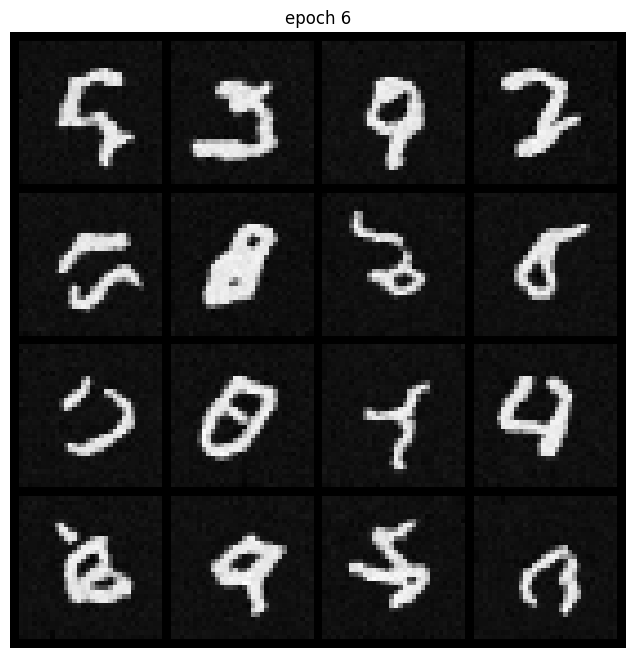

loss for epoch 6: 0.0141: 100%|██████████| 938/938 [02:50<00:00,  5.50it/s]


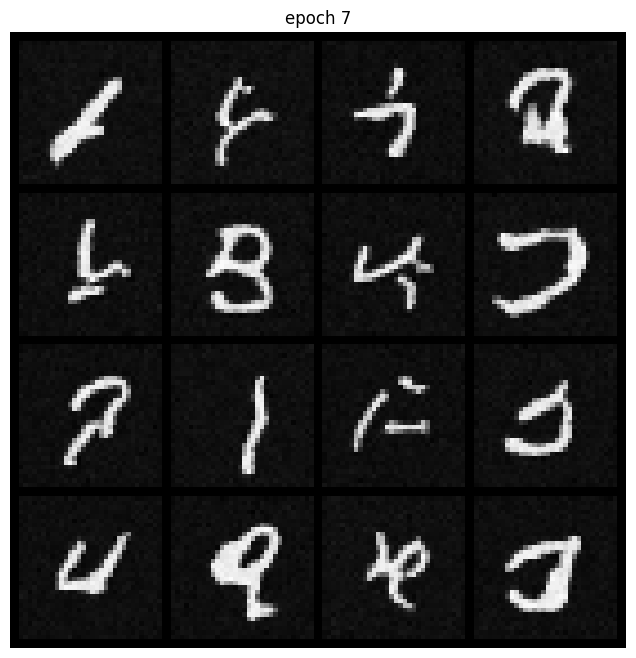

loss for epoch 7: 0.0140: 100%|██████████| 938/938 [02:49<00:00,  5.52it/s]


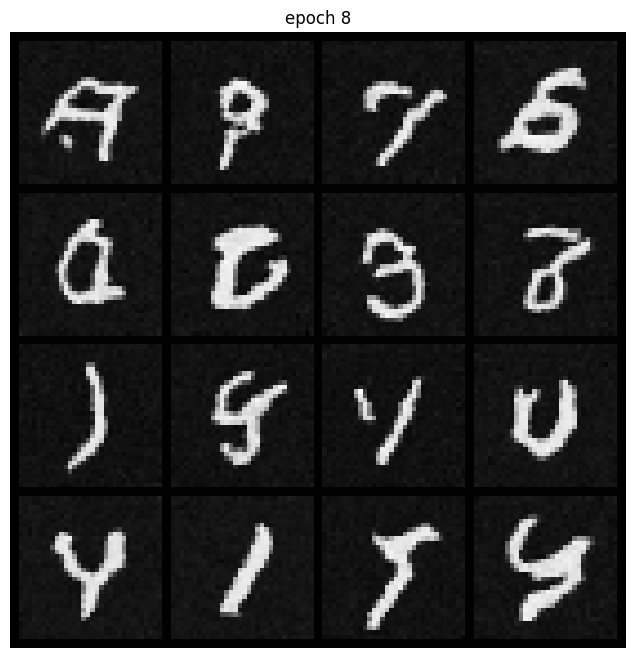

loss for epoch 8: 0.0132: 100%|██████████| 938/938 [02:51<00:00,  5.47it/s]


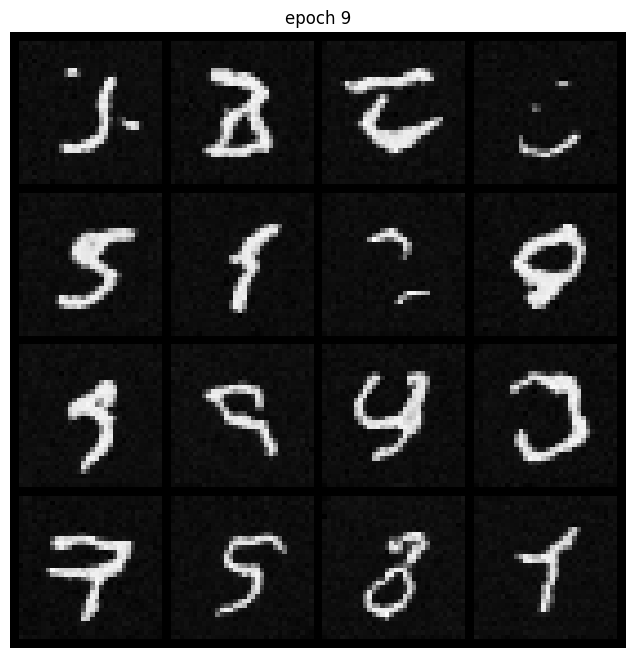

loss for epoch 9: 0.0128: 100%|██████████| 938/938 [02:50<00:00,  5.51it/s]


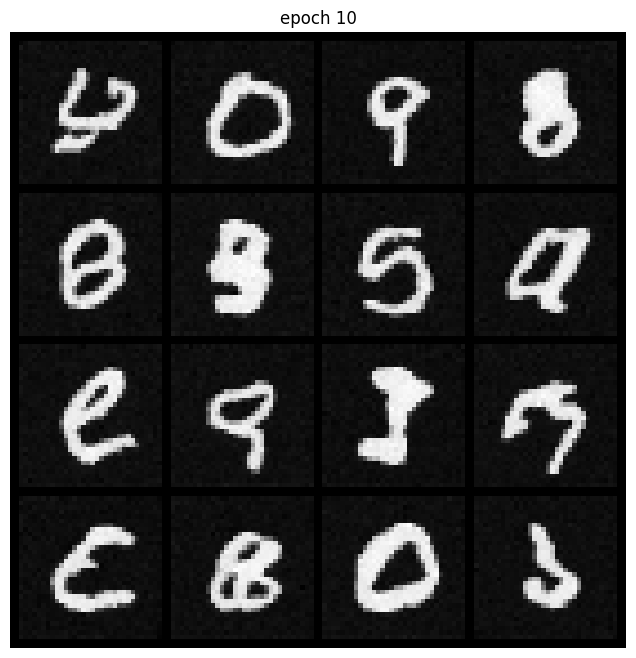

loss for epoch 10: 0.0126: 100%|██████████| 938/938 [02:51<00:00,  5.48it/s]


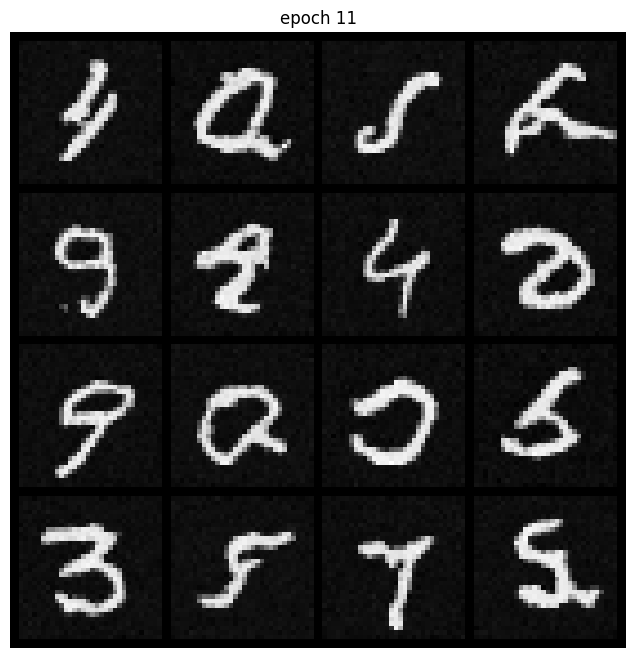

loss for epoch 11: 0.0127: 100%|██████████| 938/938 [02:51<00:00,  5.47it/s]


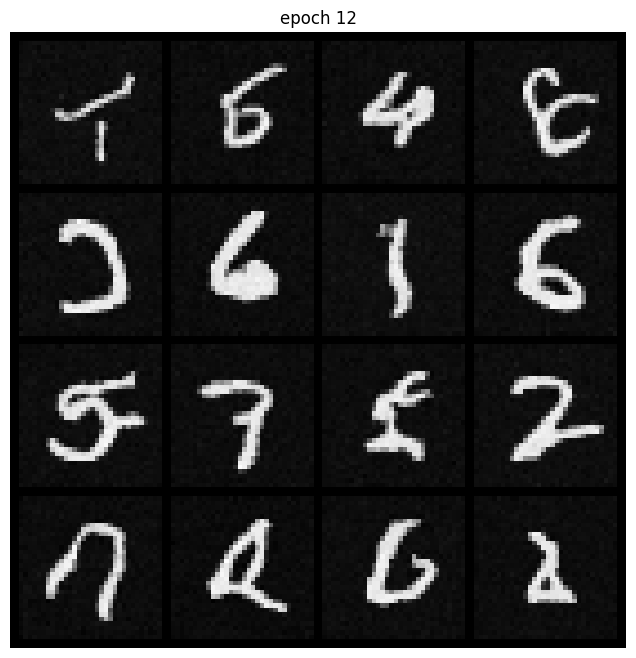

loss for epoch 12: 0.0124: 100%|██████████| 938/938 [02:51<00:00,  5.47it/s]


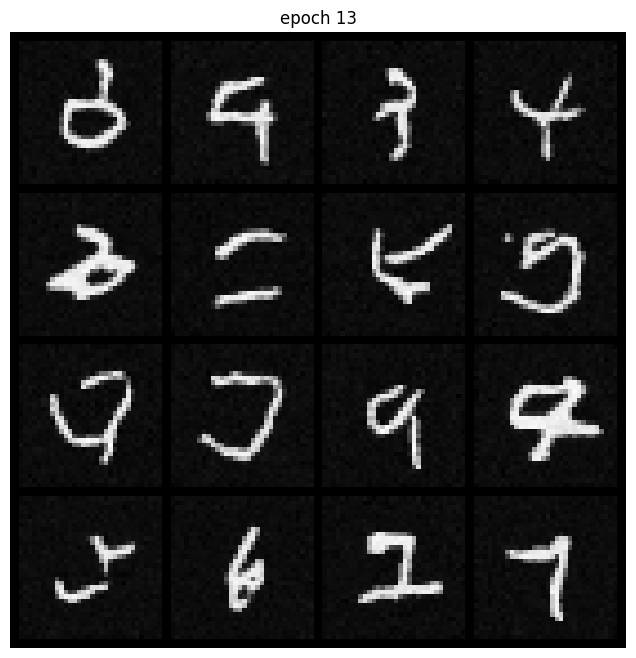

loss for epoch 13: 0.0122: 100%|██████████| 938/938 [02:50<00:00,  5.49it/s]


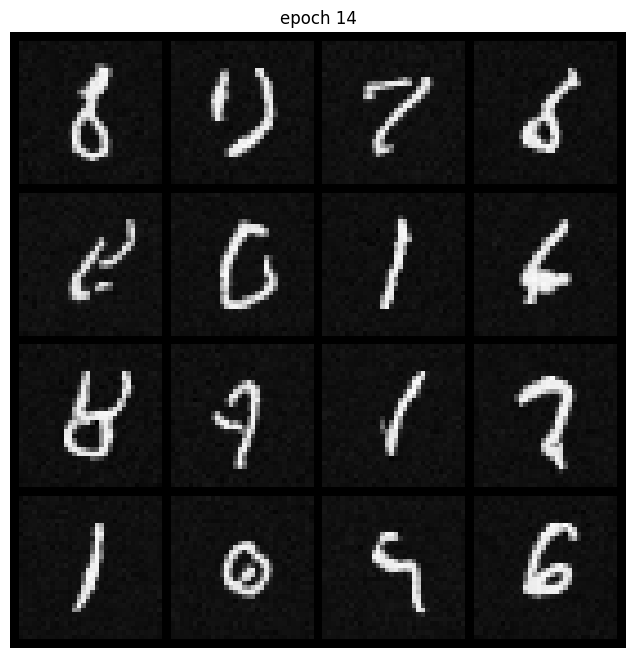

loss for epoch 14: 0.0120: 100%|██████████| 938/938 [02:49<00:00,  5.52it/s]


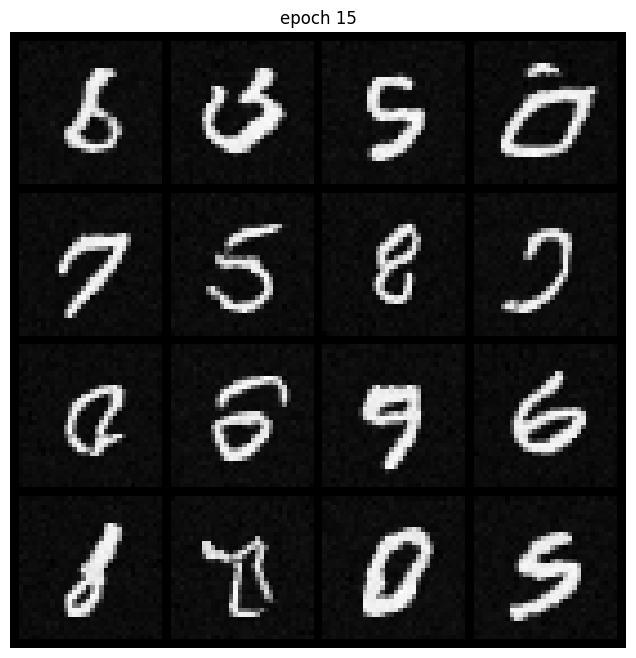

loss for epoch 15: 0.0119: 100%|██████████| 938/938 [02:50<00:00,  5.50it/s]


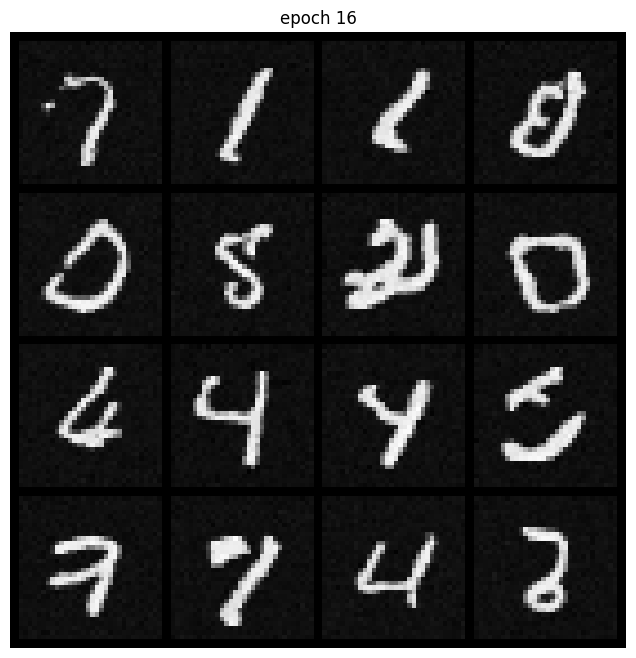

loss for epoch 16: 0.0118: 100%|██████████| 938/938 [02:50<00:00,  5.51it/s]


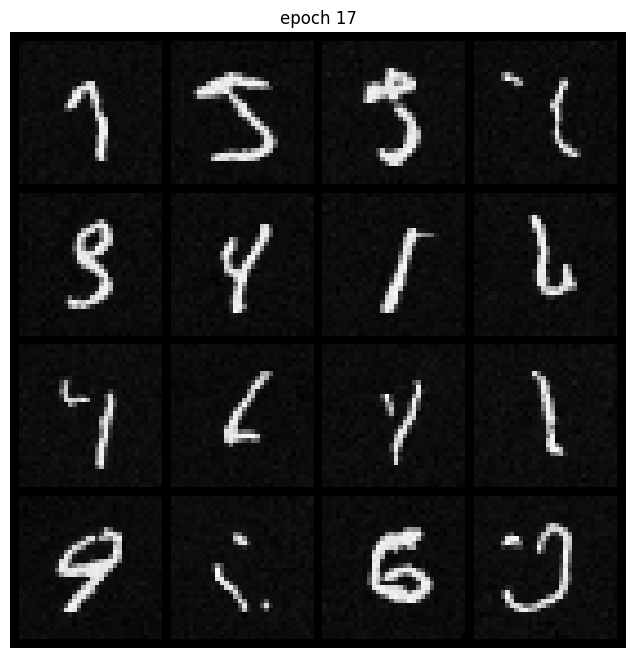

loss for epoch 17: 0.0119: 100%|██████████| 938/938 [02:51<00:00,  5.47it/s]


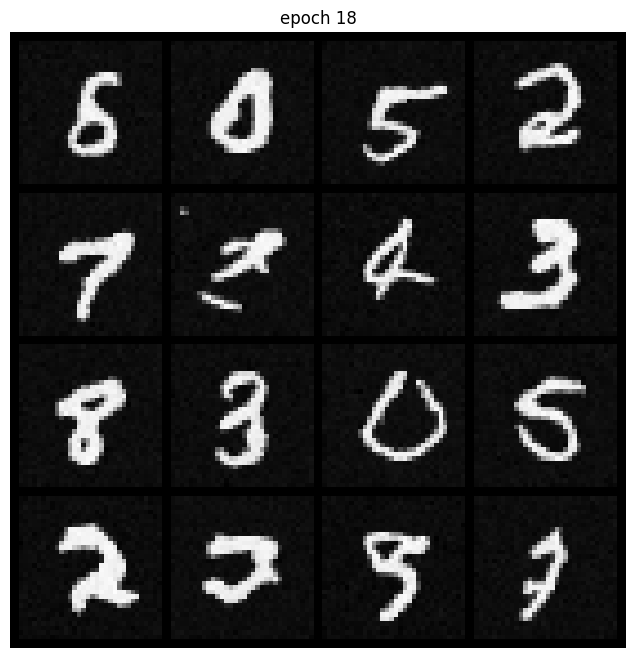

loss for epoch 18: 0.0115: 100%|██████████| 938/938 [02:52<00:00,  5.44it/s]


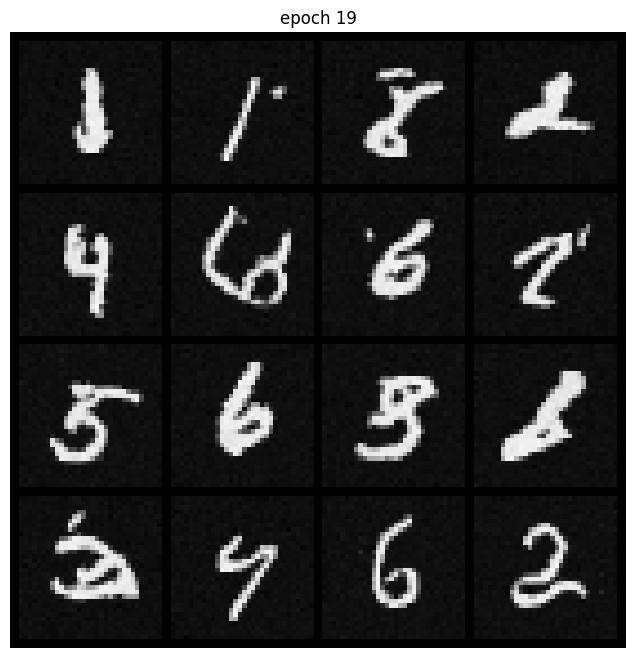

loss for epoch 19: 0.0117: 100%|██████████| 938/938 [02:54<00:00,  5.38it/s]


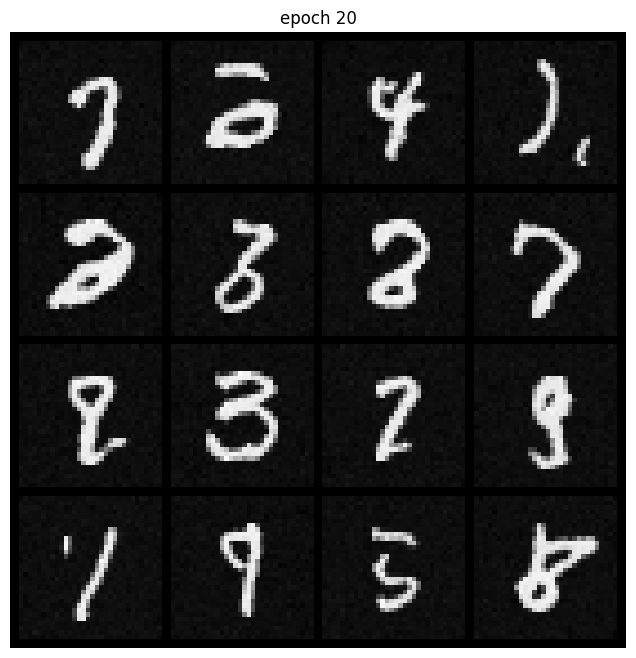

loss for epoch 20: 0.0116: 100%|██████████| 938/938 [02:54<00:00,  5.38it/s]


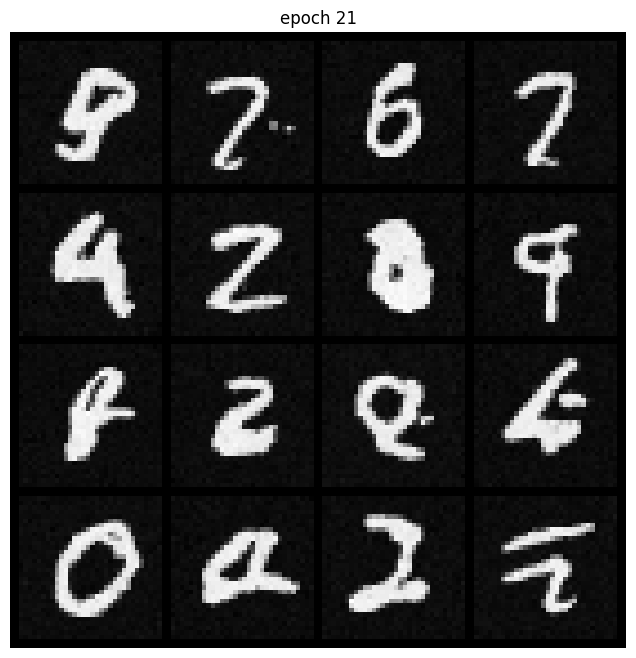

loss for epoch 21: 0.0116: 100%|██████████| 938/938 [02:54<00:00,  5.39it/s]


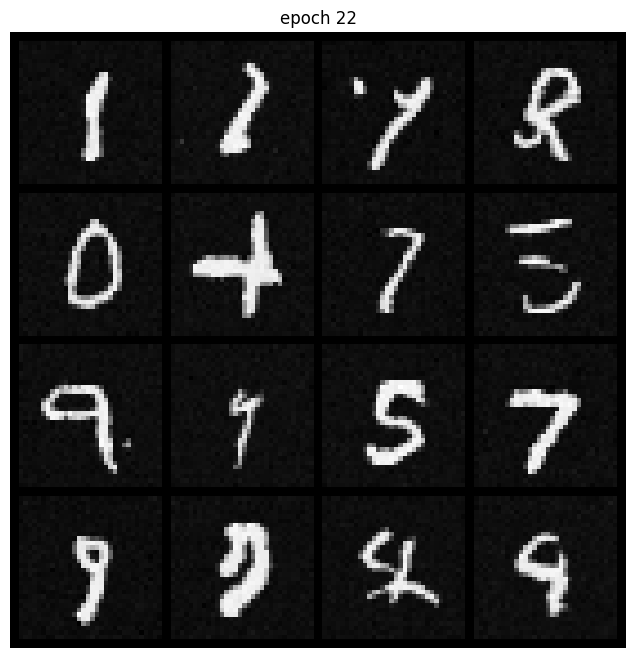

loss for epoch 22: 0.0114: 100%|██████████| 938/938 [02:51<00:00,  5.48it/s]


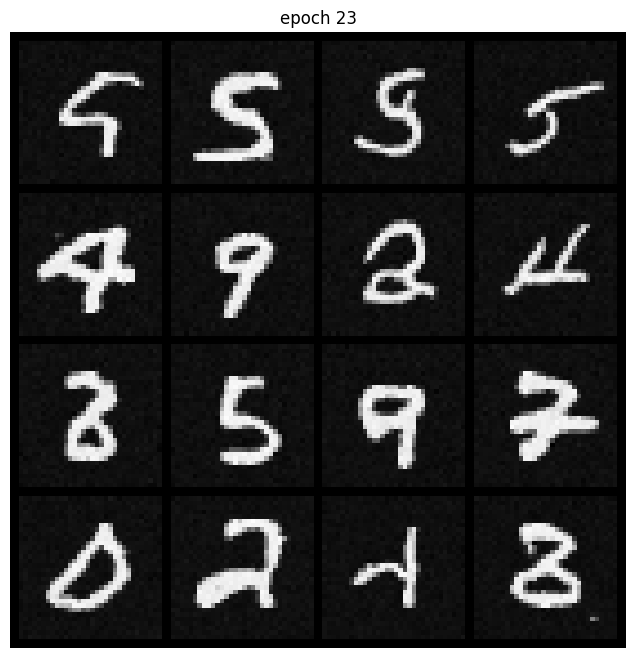

loss for epoch 23: 0.0113: 100%|██████████| 938/938 [02:46<00:00,  5.64it/s]


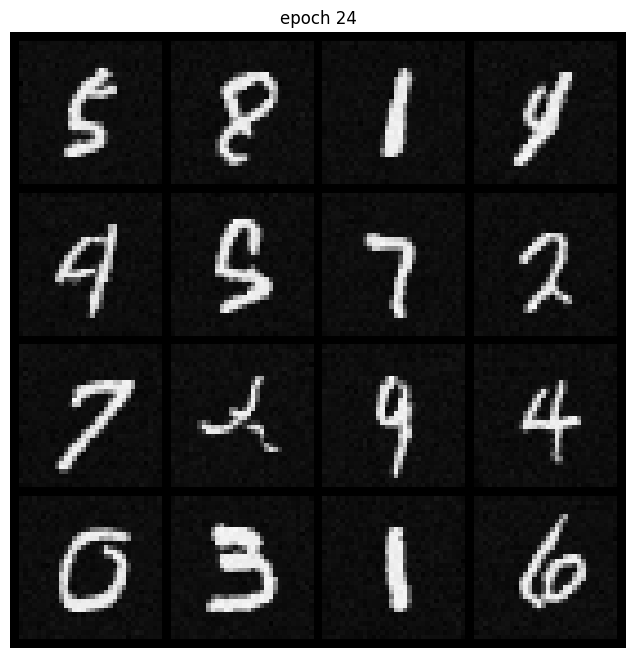

loss for epoch 24: 0.0115: 100%|██████████| 938/938 [02:44<00:00,  5.71it/s]


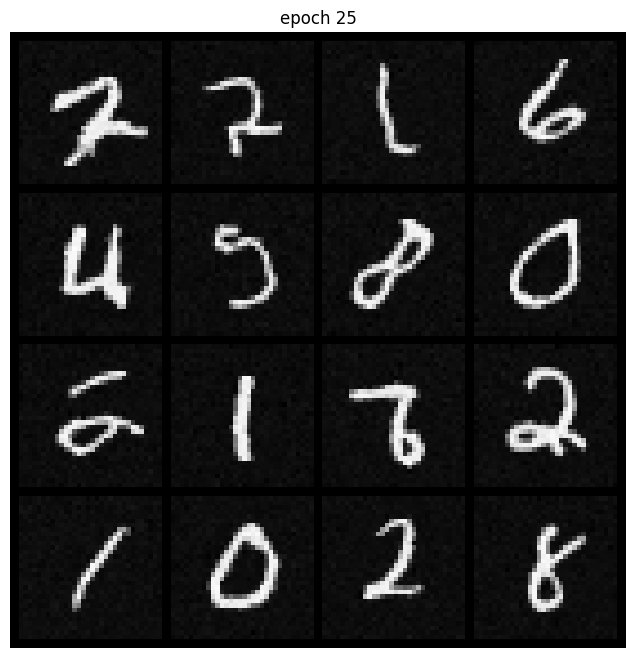

loss for epoch 25: 0.0112: 100%|██████████| 938/938 [02:45<00:00,  5.68it/s]


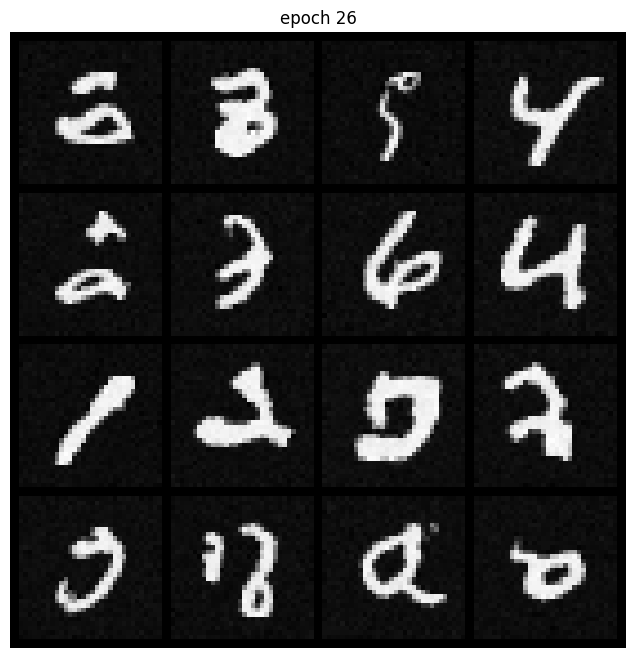

loss for epoch 26: 0.0112: 100%|██████████| 938/938 [02:45<00:00,  5.68it/s]


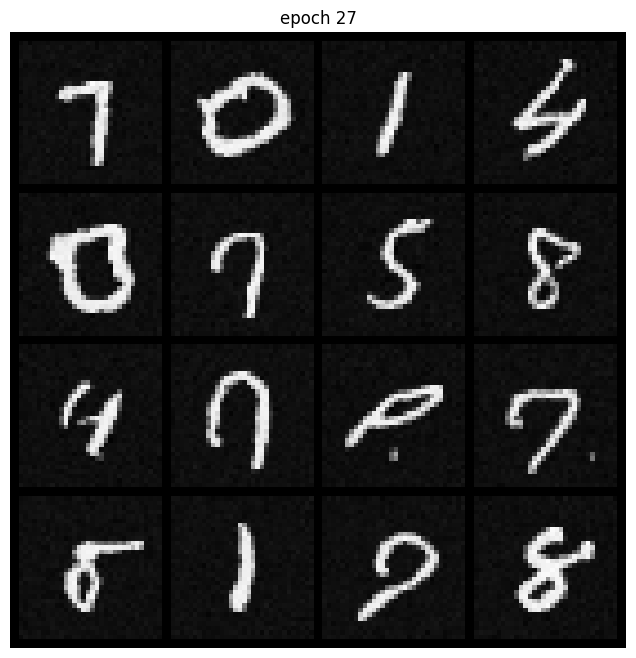

loss for epoch 27: 0.0113: 100%|██████████| 938/938 [02:44<00:00,  5.69it/s]


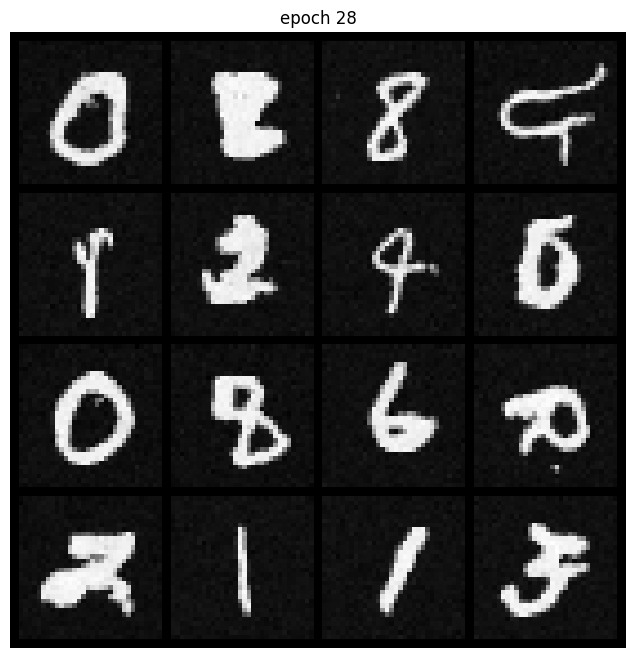

loss for epoch 28: 0.0112: 100%|██████████| 938/938 [02:43<00:00,  5.72it/s]


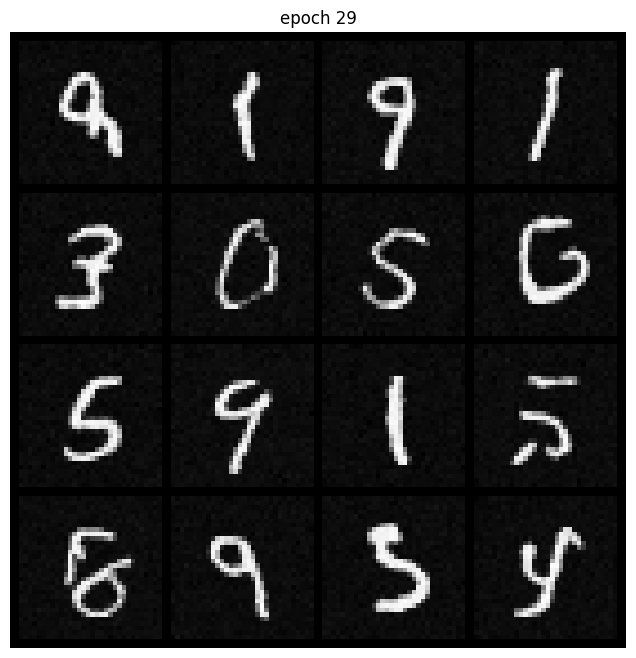

loss for epoch 29: 0.0111: 100%|██████████| 938/938 [02:42<00:00,  5.78it/s]


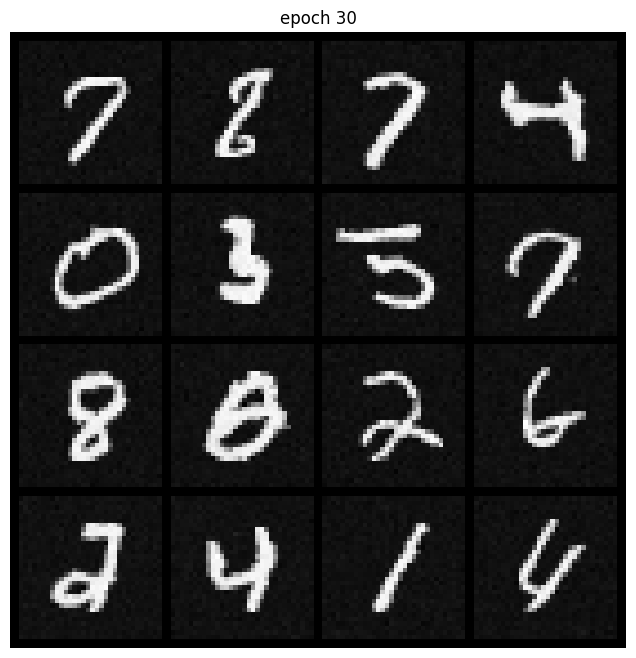

loss for epoch 30: 0.0111: 100%|██████████| 938/938 [02:43<00:00,  5.74it/s]


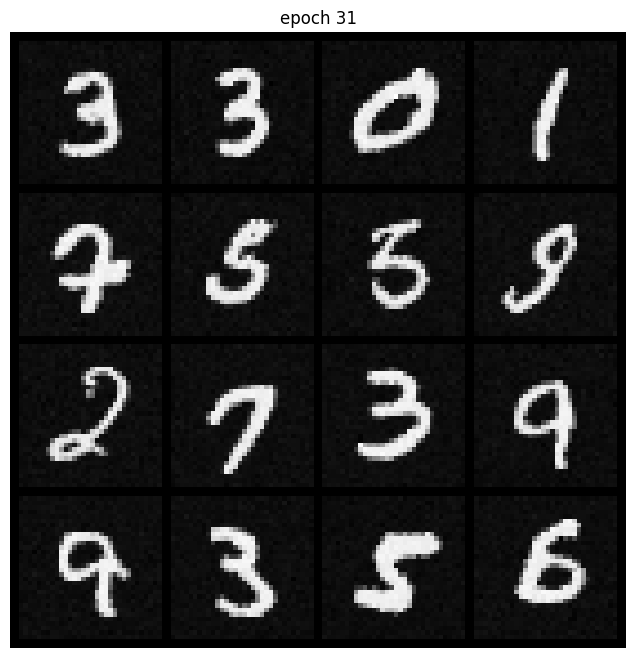

loss for epoch 31: 0.0110: 100%|██████████| 938/938 [02:45<00:00,  5.68it/s]


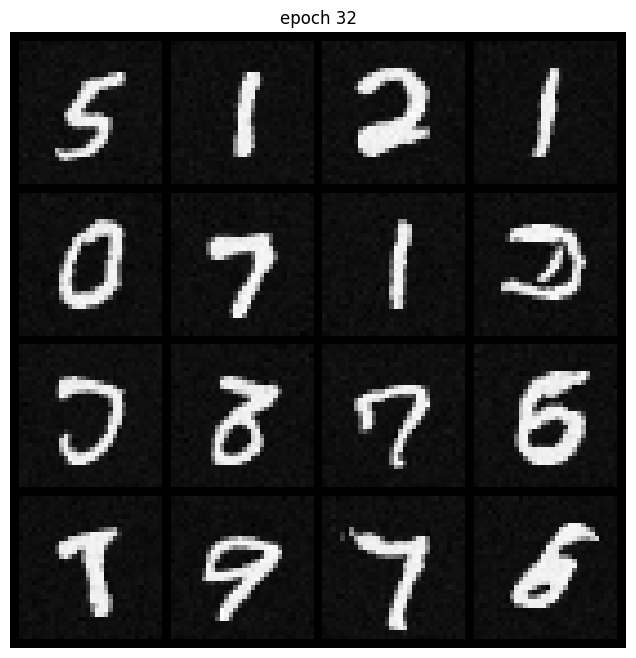

loss for epoch 32: 0.0111: 100%|██████████| 938/938 [02:44<00:00,  5.69it/s]


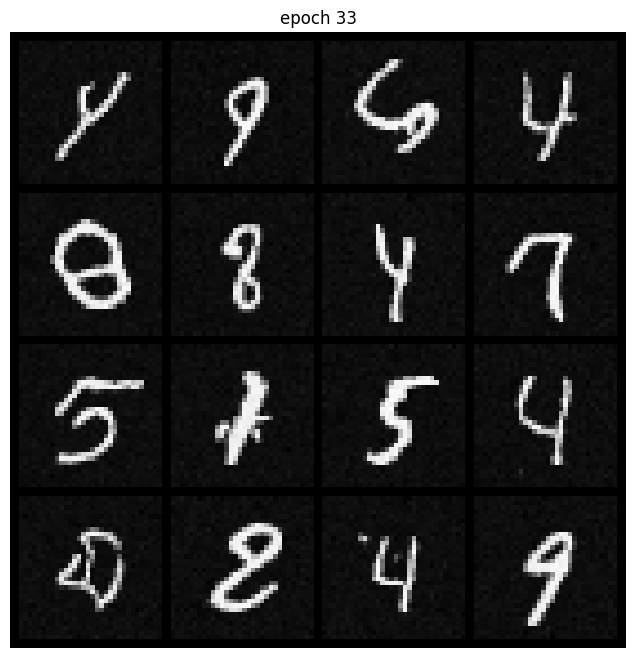

loss for epoch 33: 0.0110: 100%|██████████| 938/938 [02:44<00:00,  5.69it/s]


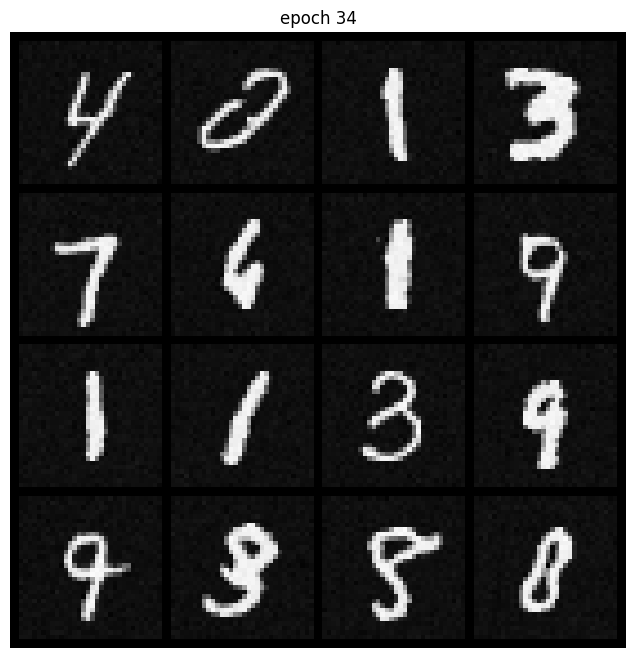

loss for epoch 34: 0.0110: 100%|██████████| 938/938 [02:41<00:00,  5.79it/s]


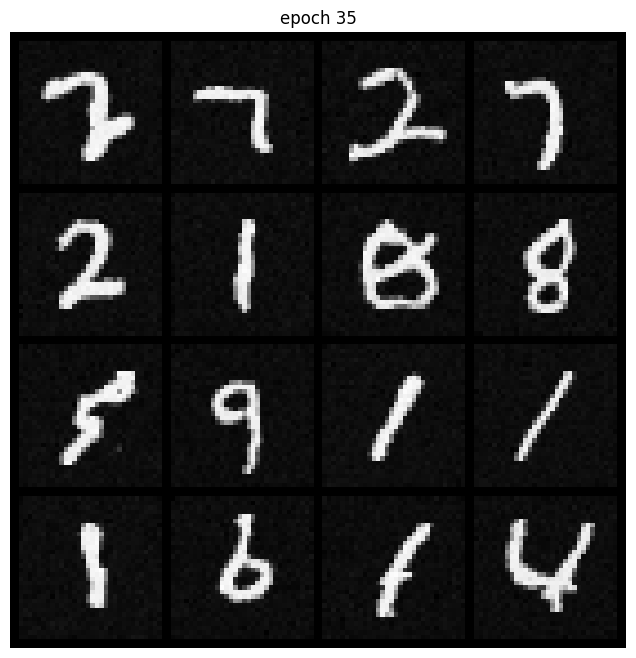

loss for epoch 35: 0.0111: 100%|██████████| 938/938 [02:41<00:00,  5.82it/s]


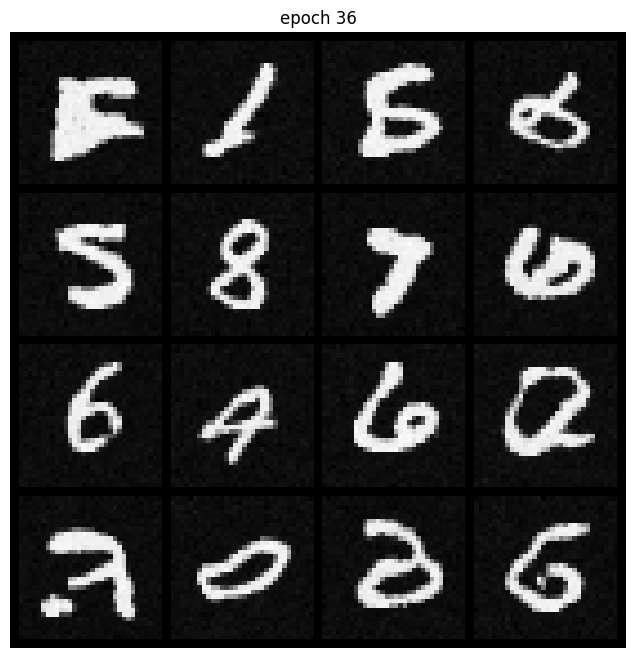

loss for epoch 36: 0.0109: 100%|██████████| 938/938 [02:44<00:00,  5.71it/s]


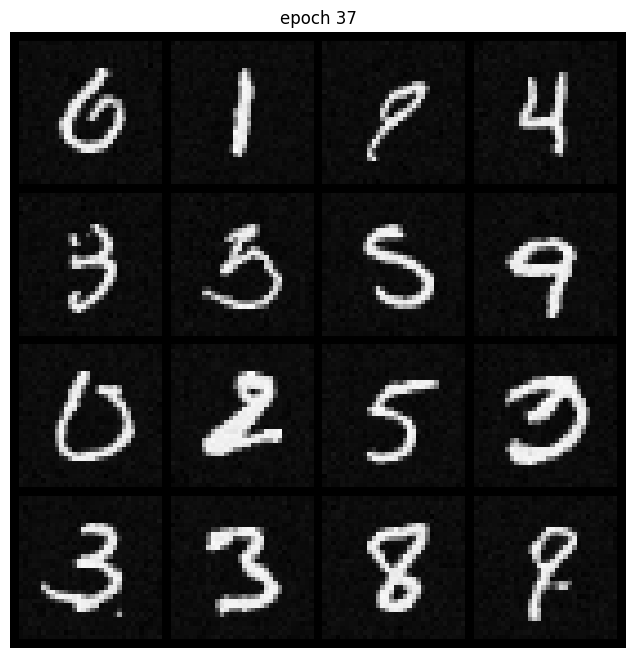

loss for epoch 37: 0.0109: 100%|██████████| 938/938 [02:43<00:00,  5.74it/s]


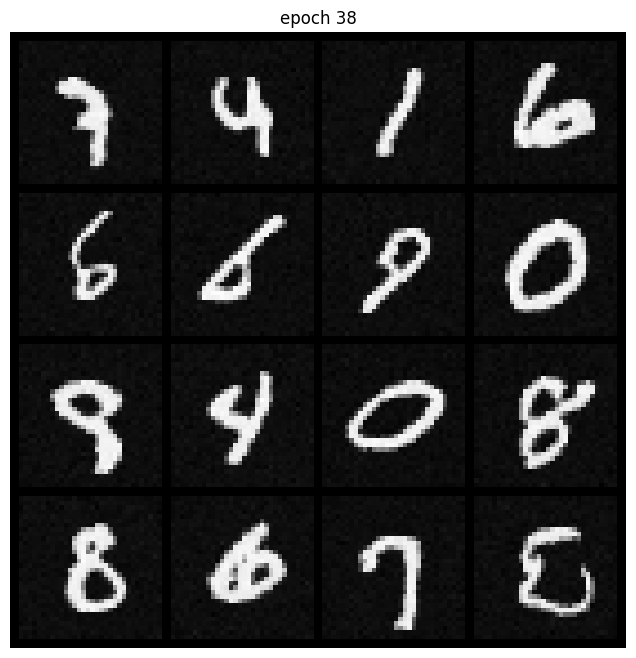

loss for epoch 38: 0.0109: 100%|██████████| 938/938 [02:42<00:00,  5.76it/s]


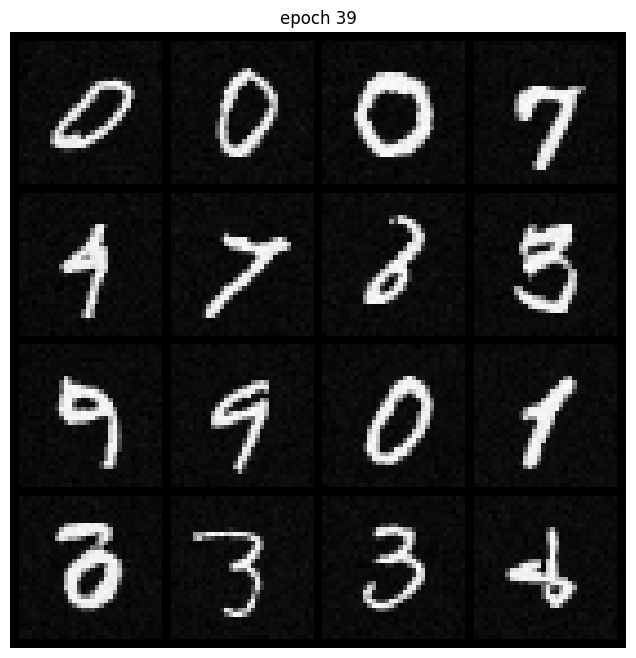

loss for epoch 39: 0.0109: 100%|██████████| 938/938 [02:42<00:00,  5.79it/s]


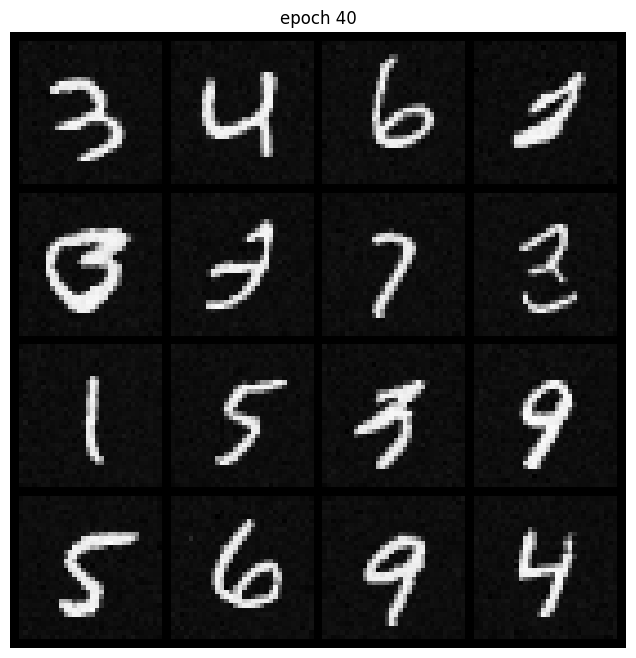

loss for epoch 40: 0.0109: 100%|██████████| 938/938 [02:49<00:00,  5.52it/s]


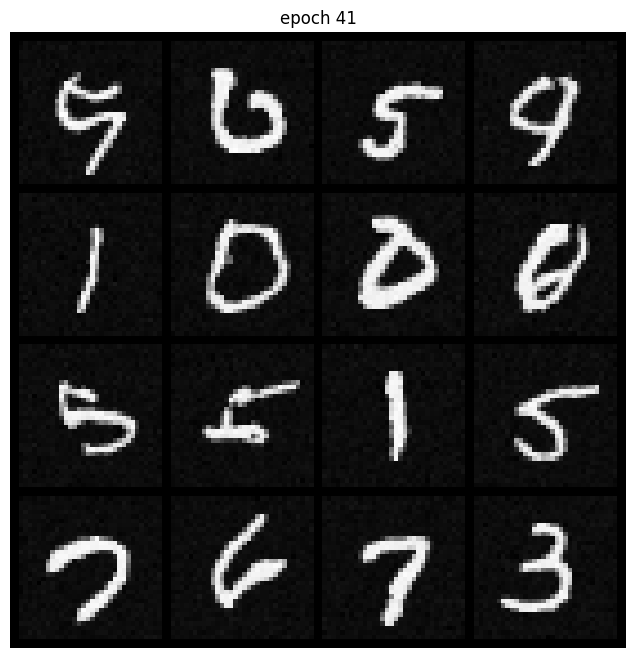

loss for epoch 41: 0.0108: 100%|██████████| 938/938 [02:51<00:00,  5.47it/s]


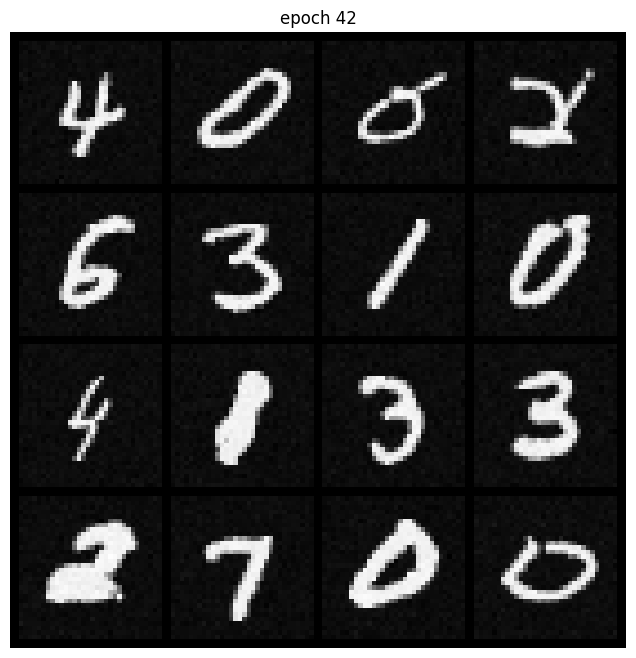

loss for epoch 42: 0.0108: 100%|██████████| 938/938 [02:51<00:00,  5.47it/s]


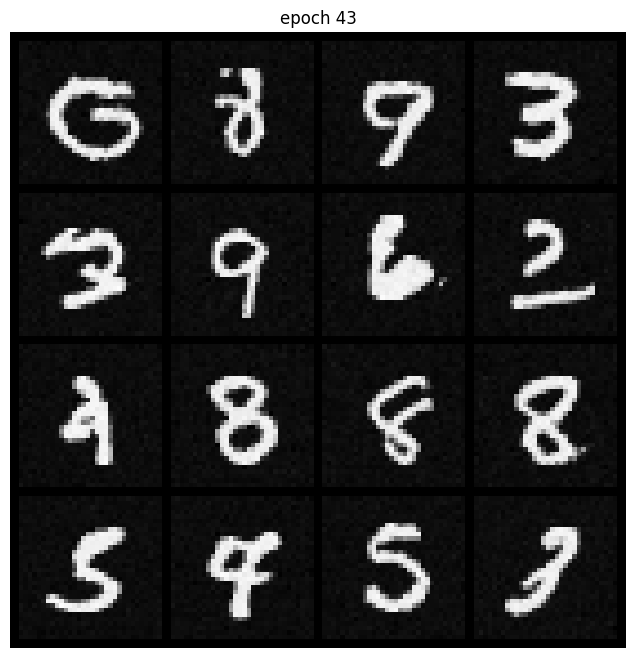

loss for epoch 43: 0.0108: 100%|██████████| 938/938 [02:51<00:00,  5.47it/s]


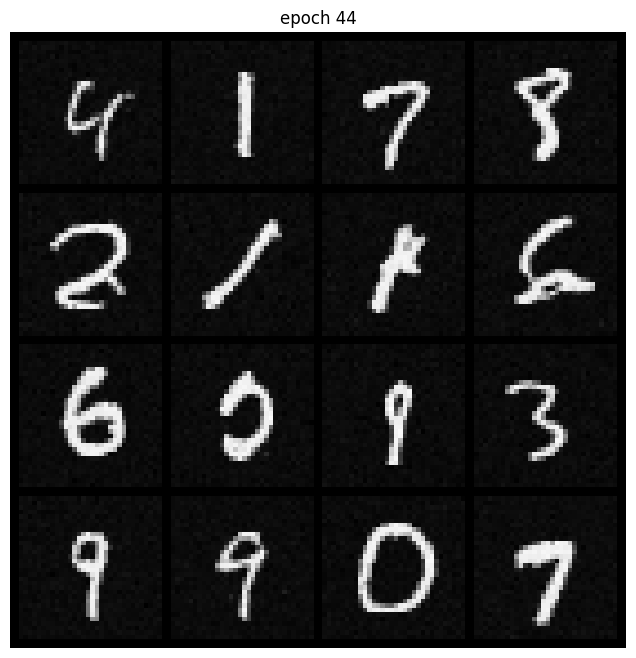

loss for epoch 44: 0.0109: 100%|██████████| 938/938 [02:50<00:00,  5.51it/s]


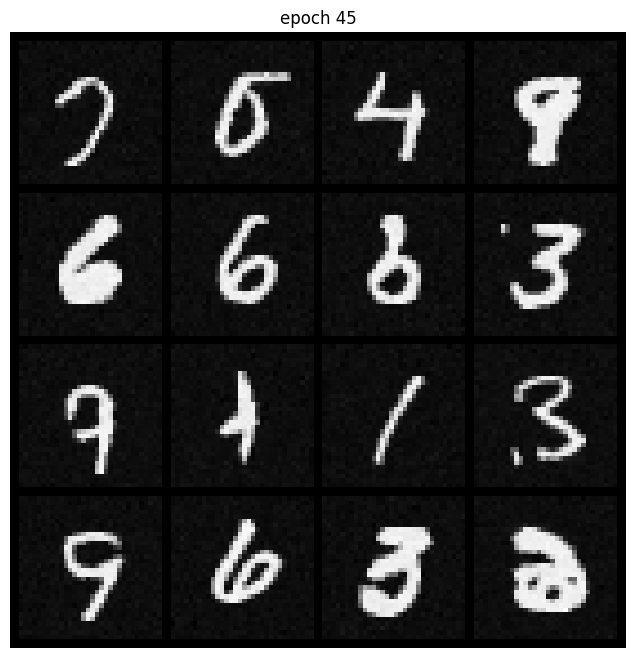

loss for epoch 45: 0.0108: 100%|██████████| 938/938 [02:50<00:00,  5.51it/s]


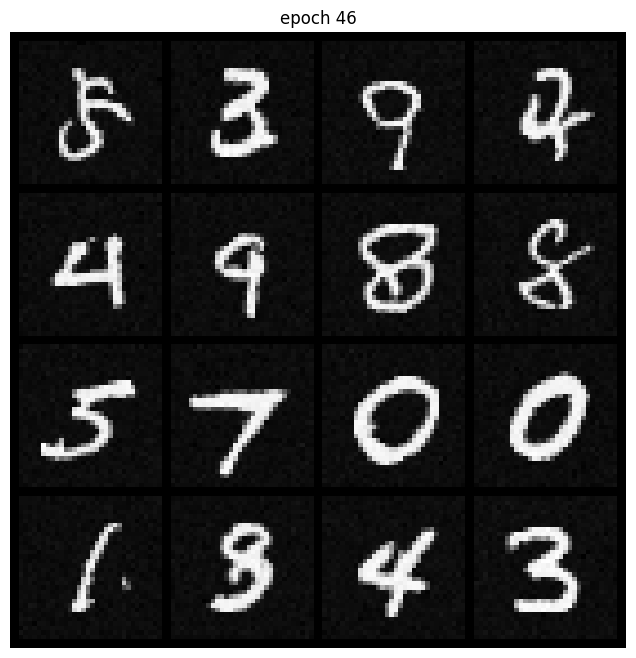

loss for epoch 46: 0.0107: 100%|██████████| 938/938 [02:51<00:00,  5.47it/s]


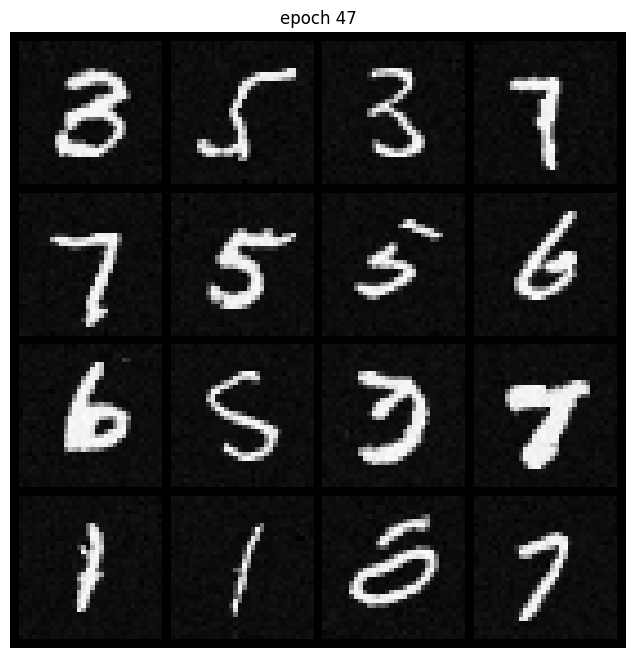

loss for epoch 47: 0.0107: 100%|██████████| 938/938 [02:50<00:00,  5.50it/s]


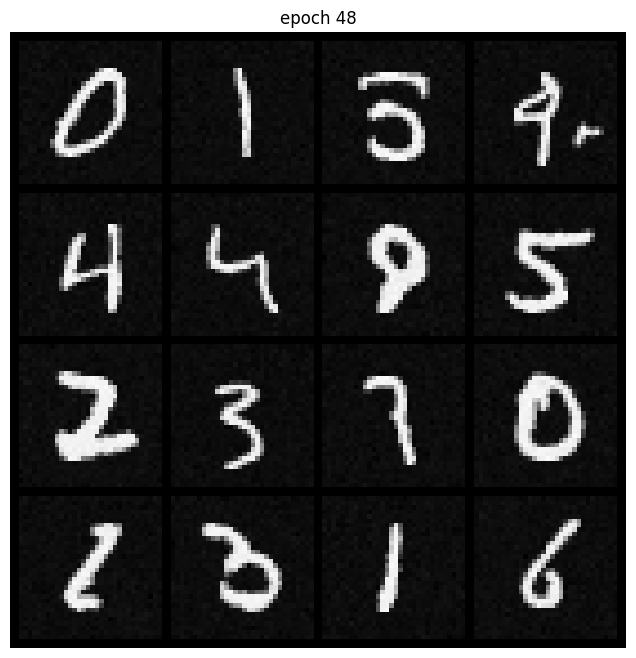

loss for epoch 48: 0.0107: 100%|██████████| 938/938 [02:51<00:00,  5.47it/s]


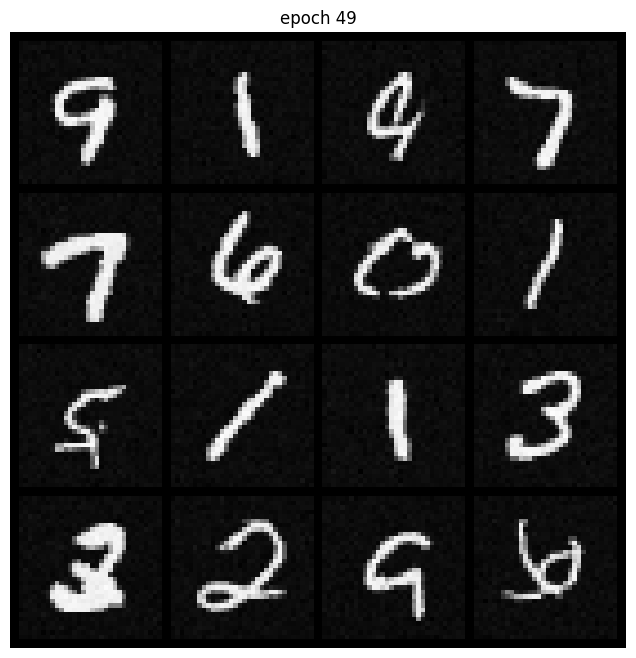

loss for epoch 49: 0.0107: 100%|██████████| 938/938 [02:49<00:00,  5.52it/s]


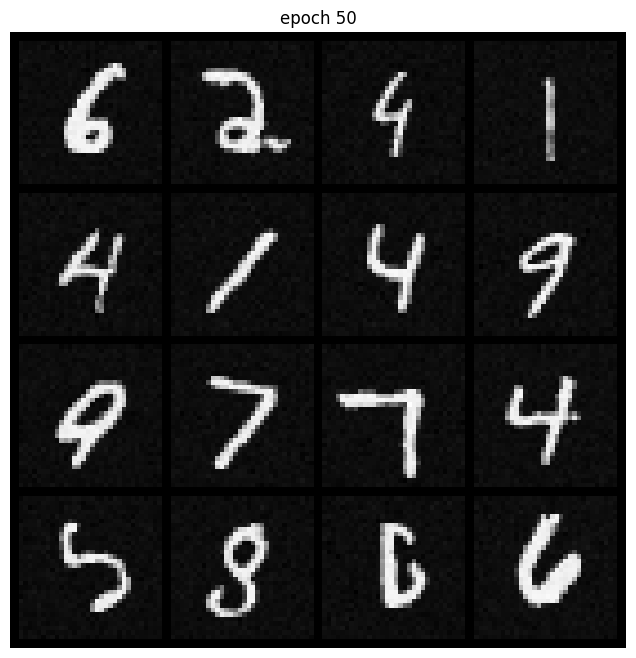

loss for epoch 50: 0.0106: 100%|██████████| 938/938 [02:50<00:00,  5.51it/s]


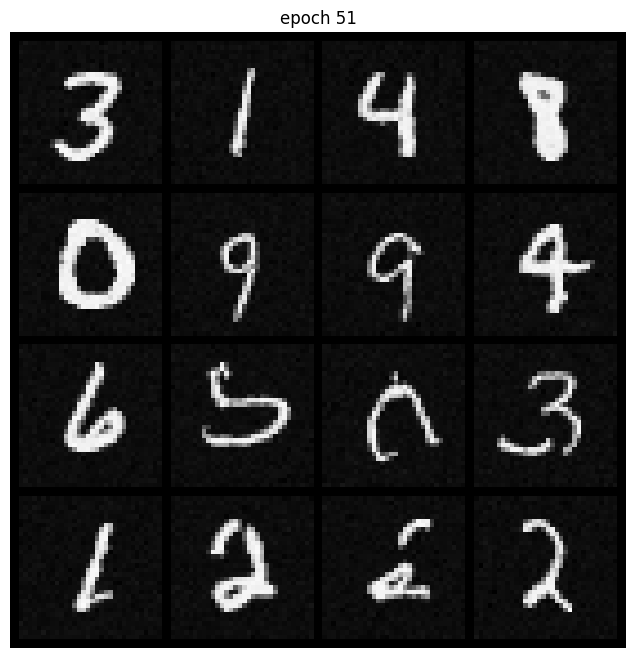

loss for epoch 51: 0.0107: 100%|██████████| 938/938 [02:49<00:00,  5.52it/s]


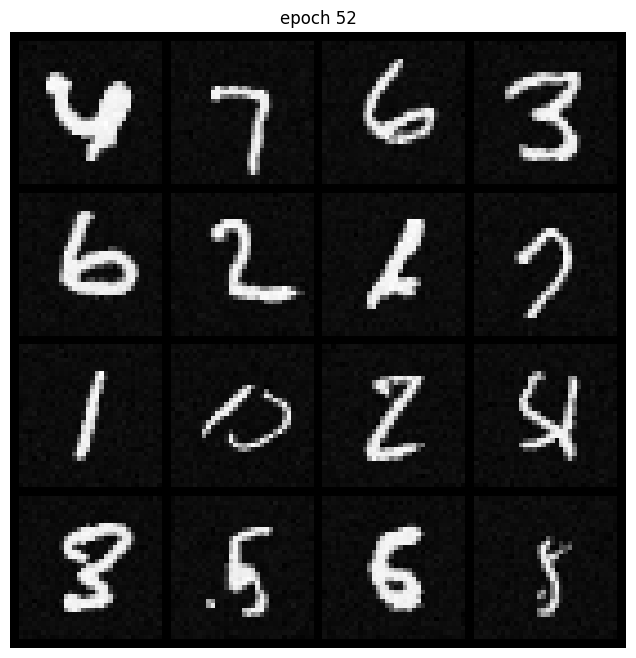

loss for epoch 52: 0.0108: 100%|██████████| 938/938 [02:49<00:00,  5.53it/s]


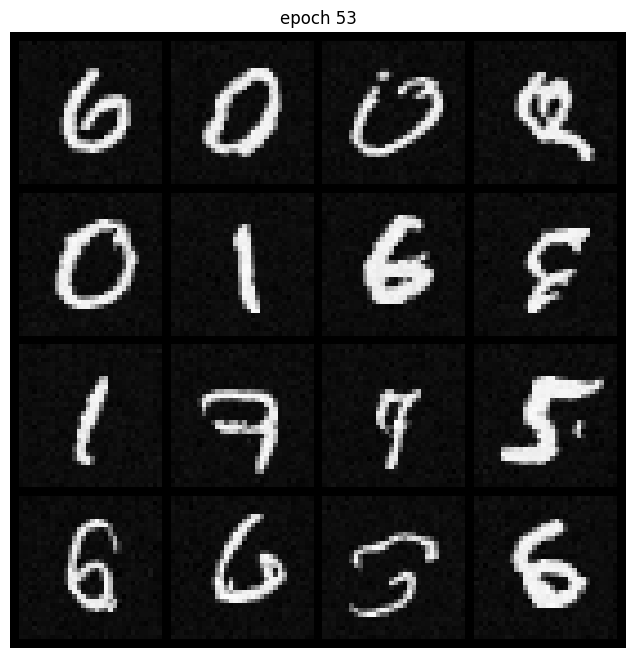

loss for epoch 53: 0.0107: 100%|██████████| 938/938 [02:51<00:00,  5.47it/s]


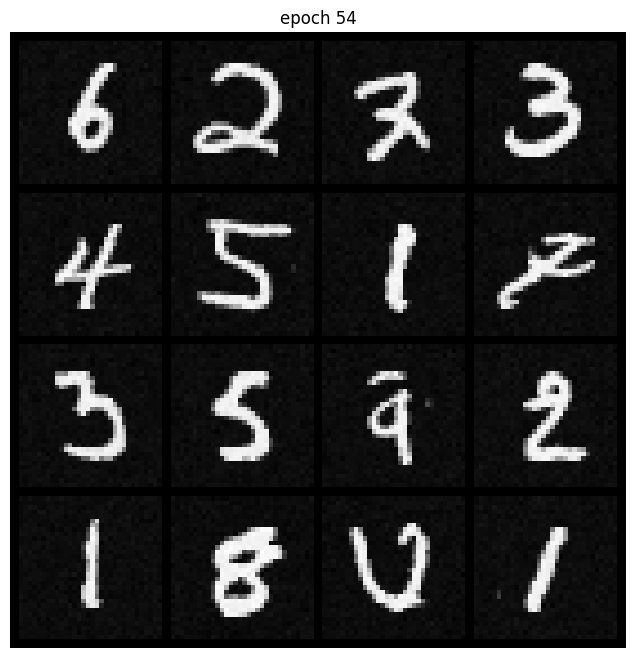

loss for epoch 54: 0.0106: 100%|██████████| 938/938 [02:49<00:00,  5.54it/s]


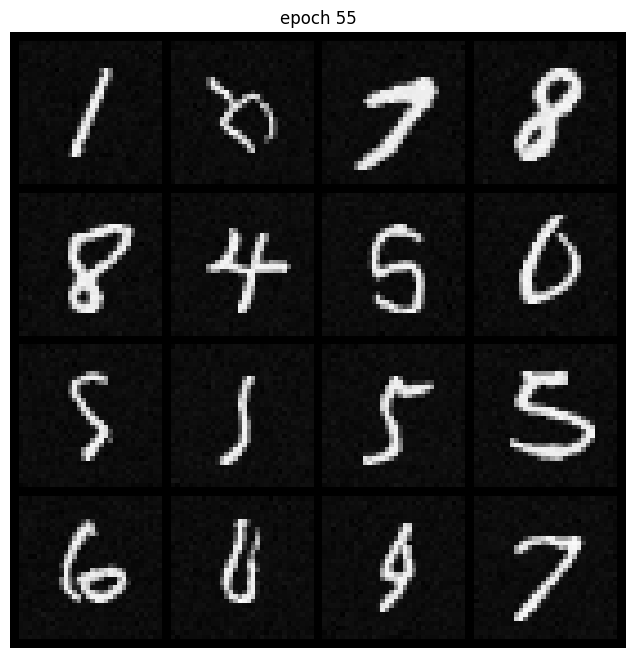

loss for epoch 55: 0.0106: 100%|██████████| 938/938 [02:50<00:00,  5.51it/s]


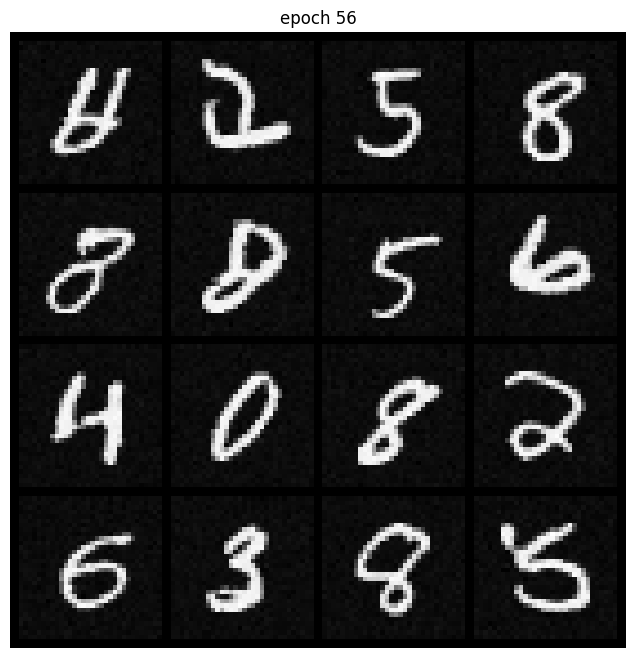

loss for epoch 56: 0.0107: 100%|██████████| 938/938 [02:50<00:00,  5.50it/s]


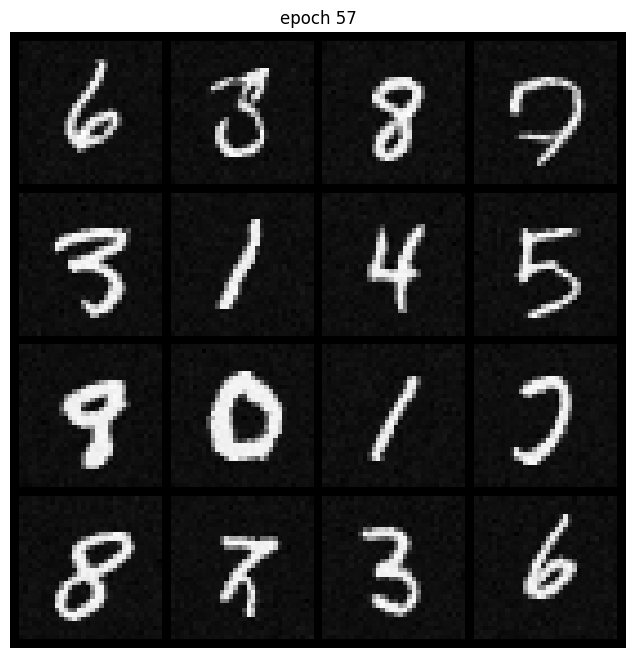

loss for epoch 57: 0.0107: 100%|██████████| 938/938 [02:51<00:00,  5.46it/s]


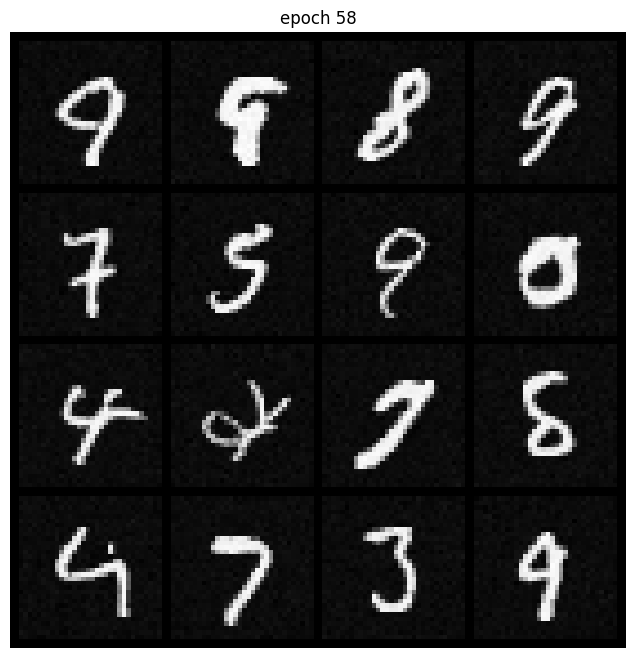

loss for epoch 58: 0.0107: 100%|██████████| 938/938 [02:51<00:00,  5.47it/s]


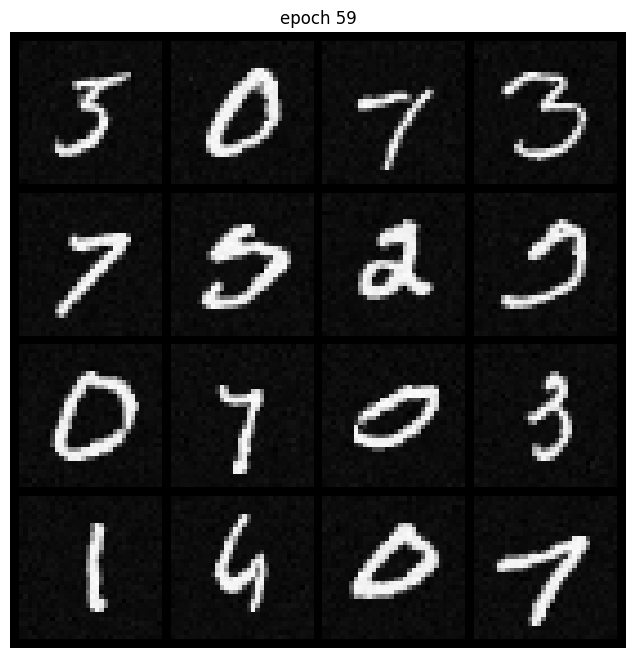

loss for epoch 59: 0.0107: 100%|██████████| 938/938 [02:52<00:00,  5.44it/s]


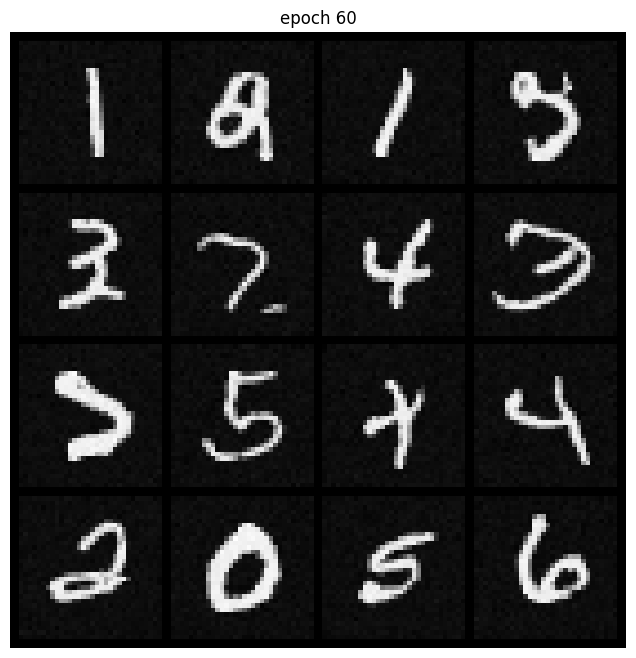

loss for epoch 60: 0.0105: 100%|██████████| 938/938 [02:52<00:00,  5.44it/s]


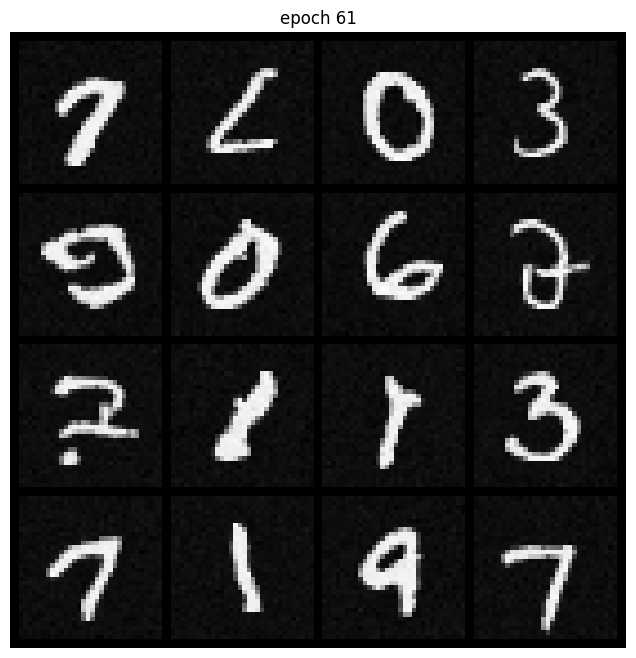

loss for epoch 61: 0.0105: 100%|██████████| 938/938 [02:50<00:00,  5.49it/s]


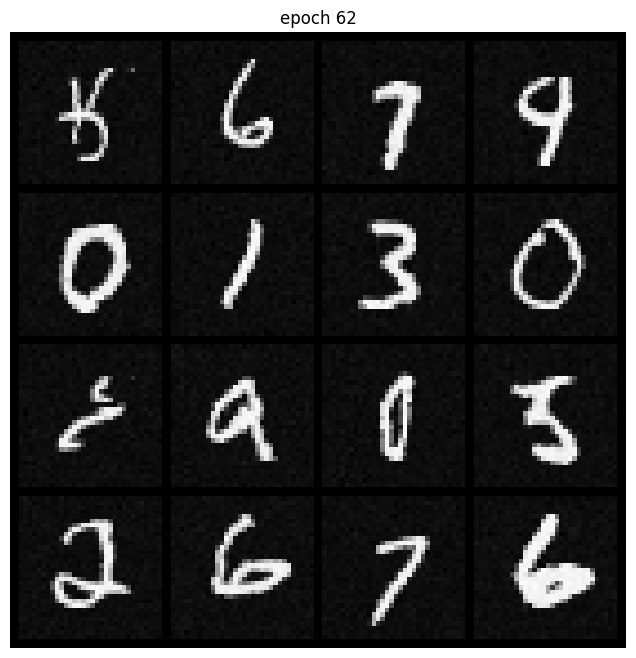

loss for epoch 62: 0.0105: 100%|██████████| 938/938 [02:49<00:00,  5.53it/s]


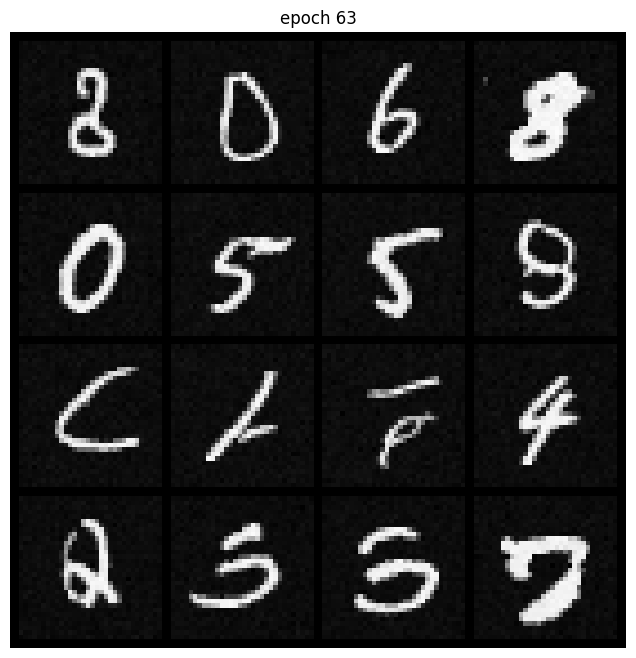

loss for epoch 63: 0.0106: 100%|██████████| 938/938 [02:49<00:00,  5.52it/s]


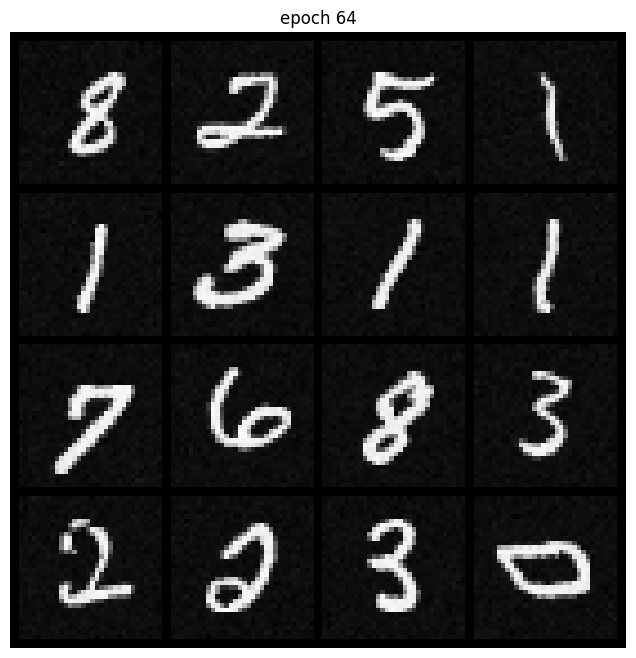

loss for epoch 64: 0.0106: 100%|██████████| 938/938 [02:49<00:00,  5.54it/s]


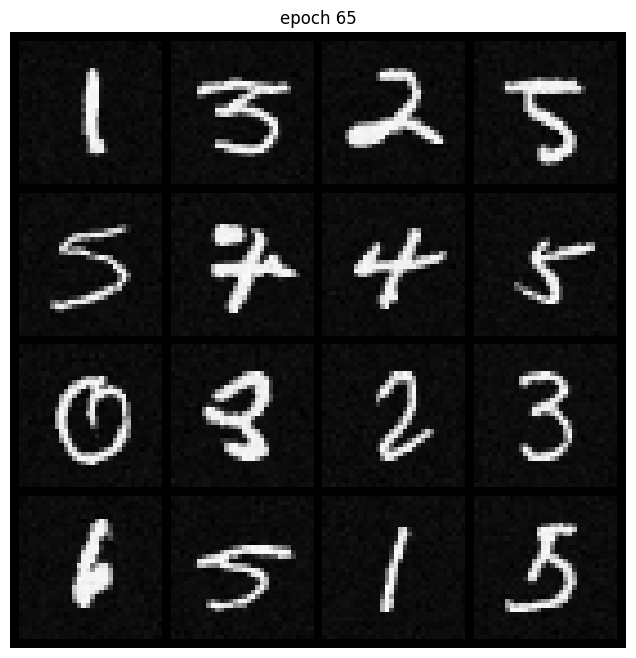

loss for epoch 65: 0.0106: 100%|██████████| 938/938 [02:50<00:00,  5.50it/s]


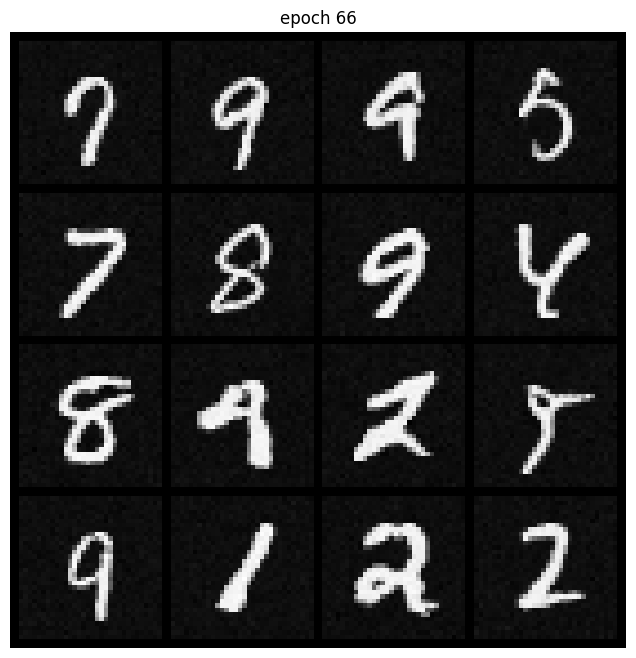

loss for epoch 66: 0.0105: 100%|██████████| 938/938 [02:51<00:00,  5.47it/s]


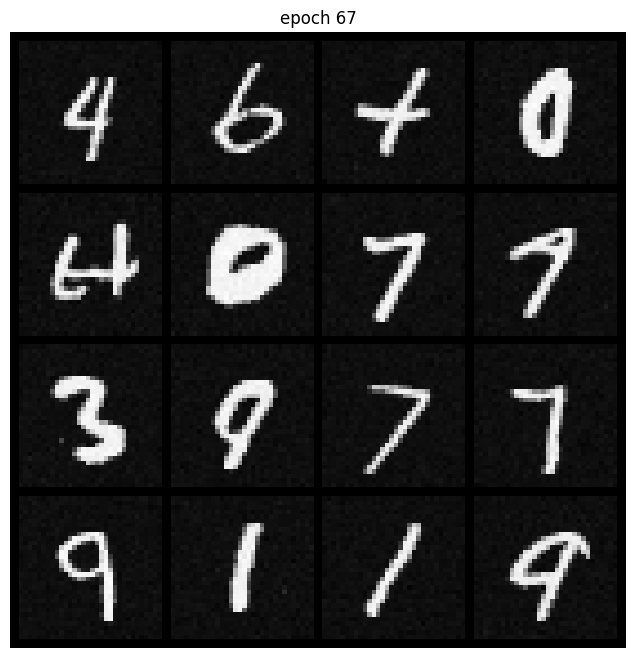

loss for epoch 67: 0.0106: 100%|██████████| 938/938 [02:49<00:00,  5.54it/s]


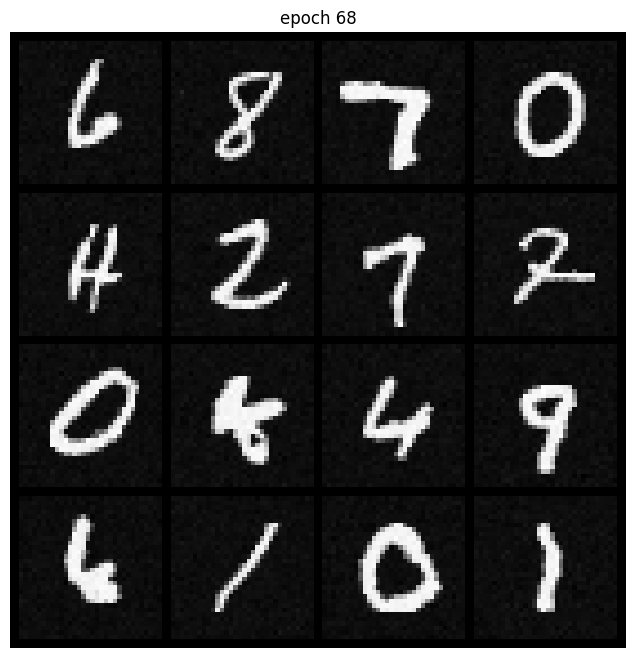

loss for epoch 68: 0.0104: 100%|██████████| 938/938 [02:52<00:00,  5.45it/s]


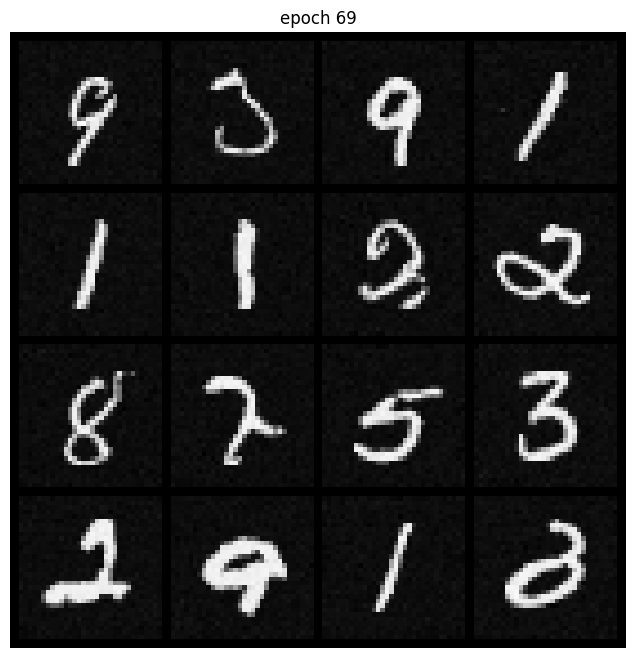

loss for epoch 69: 0.0105: 100%|██████████| 938/938 [02:49<00:00,  5.52it/s]


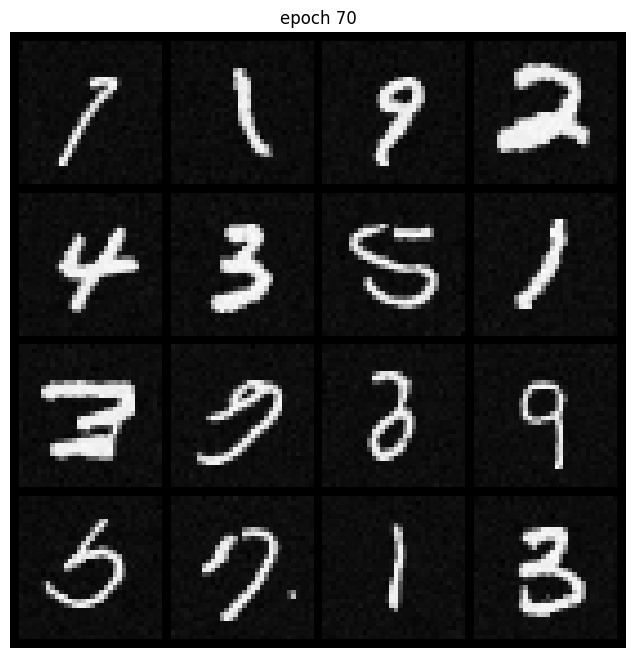

loss for epoch 70: 0.0105: 100%|██████████| 938/938 [02:50<00:00,  5.51it/s]


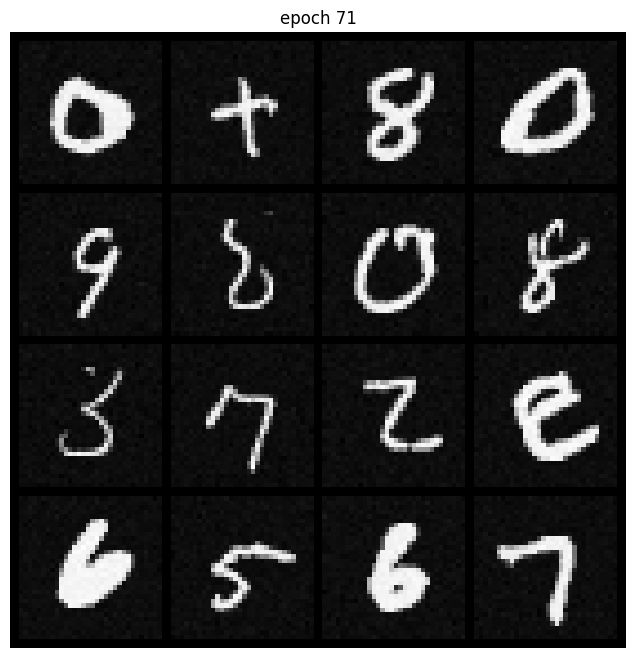

loss for epoch 71: 0.0106: 100%|██████████| 938/938 [02:50<00:00,  5.50it/s]


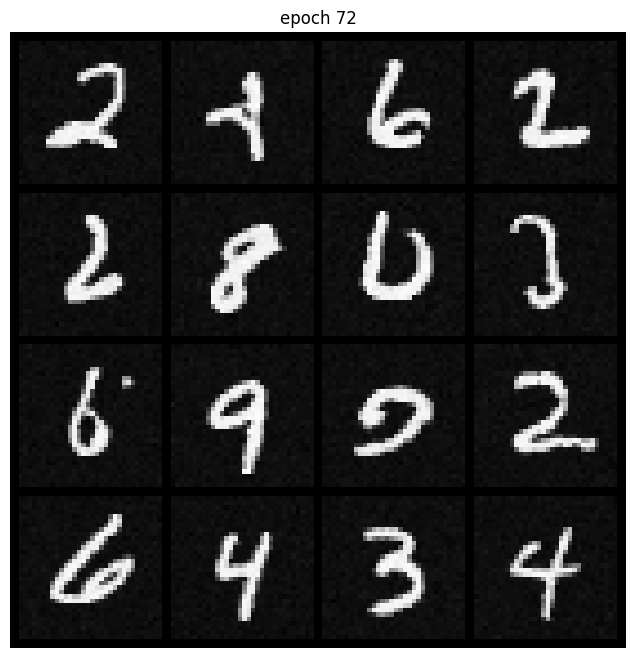

loss for epoch 72: 0.0105: 100%|██████████| 938/938 [02:49<00:00,  5.53it/s]


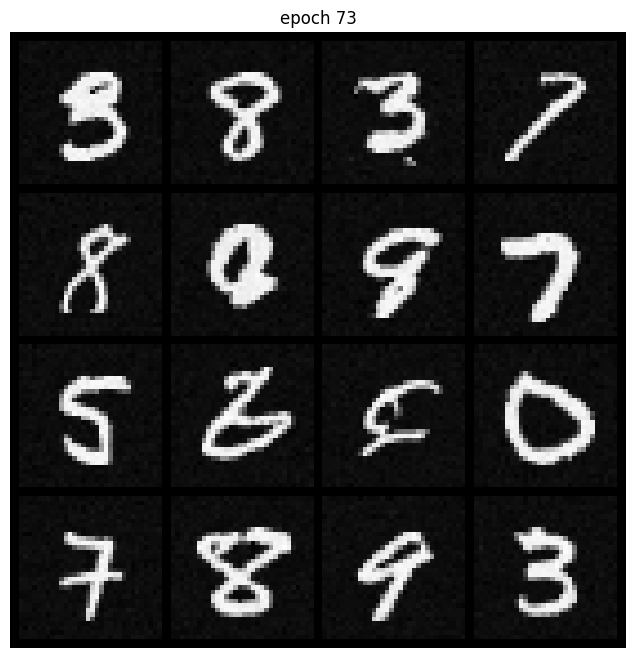

loss for epoch 73: 0.0104: 100%|██████████| 938/938 [02:50<00:00,  5.52it/s]


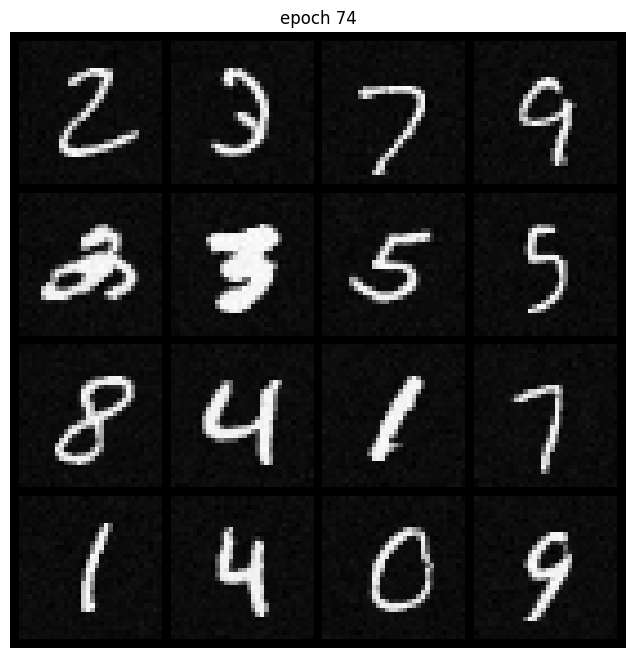

loss for epoch 74: 0.0104: 100%|██████████| 938/938 [02:51<00:00,  5.48it/s]


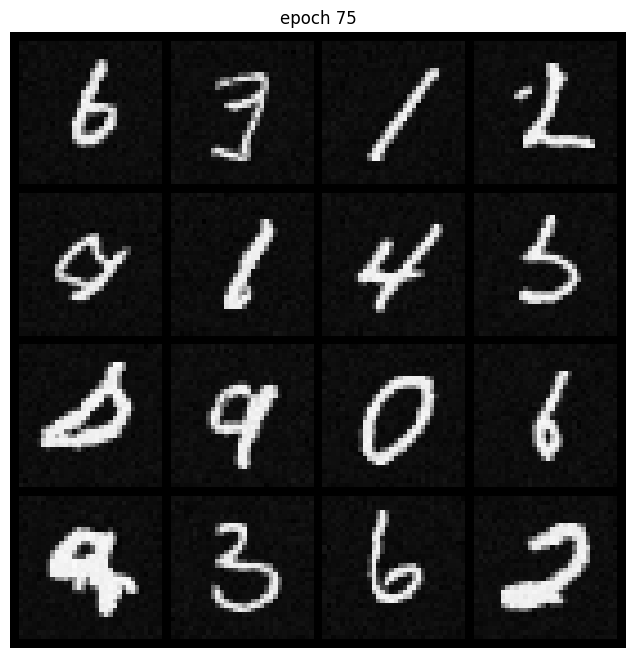

loss for epoch 75: 0.0105: 100%|██████████| 938/938 [02:49<00:00,  5.53it/s]


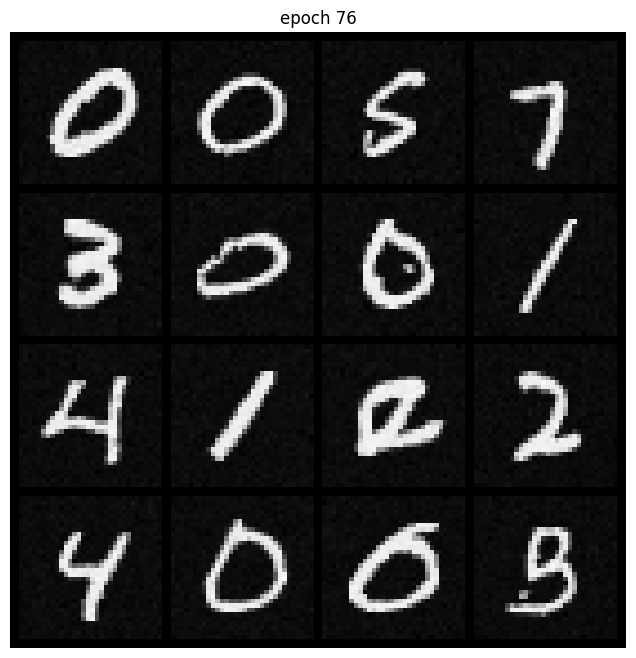

loss for epoch 76: 0.0104: 100%|██████████| 938/938 [02:49<00:00,  5.52it/s]


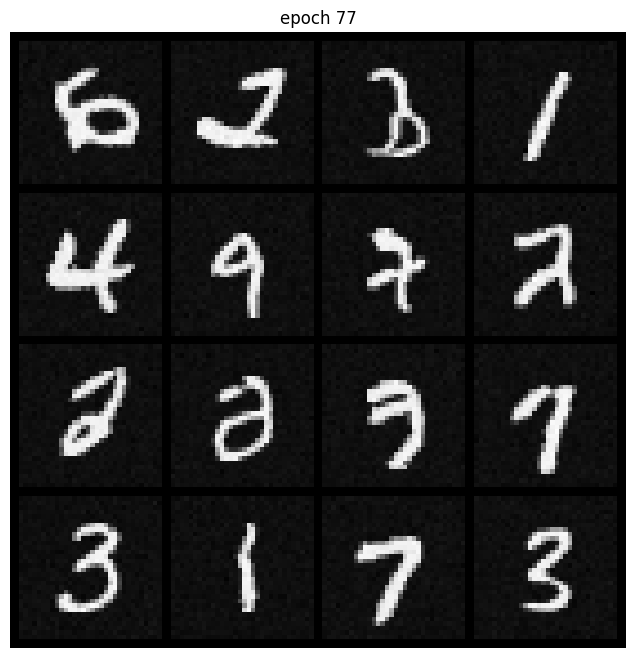

loss for epoch 77: 0.0104: 100%|██████████| 938/938 [02:53<00:00,  5.42it/s]


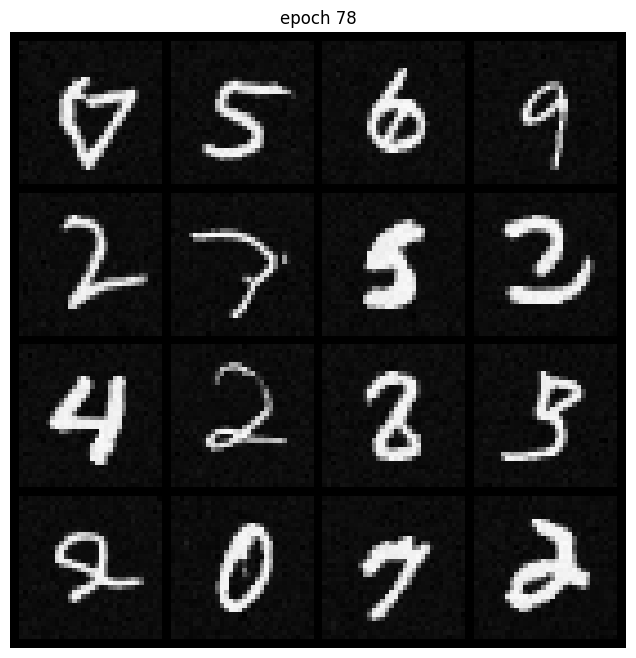

loss for epoch 78: 0.0105: 100%|██████████| 938/938 [02:53<00:00,  5.42it/s]


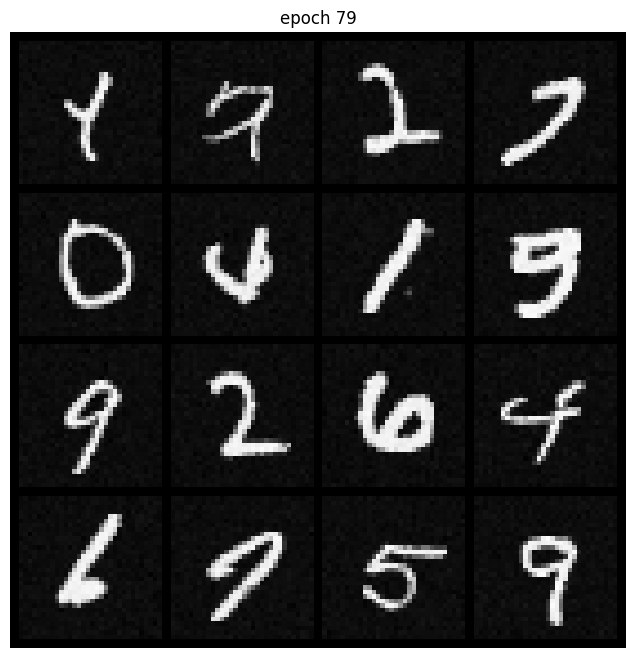

loss for epoch 79: 0.0104: 100%|██████████| 938/938 [02:52<00:00,  5.44it/s]


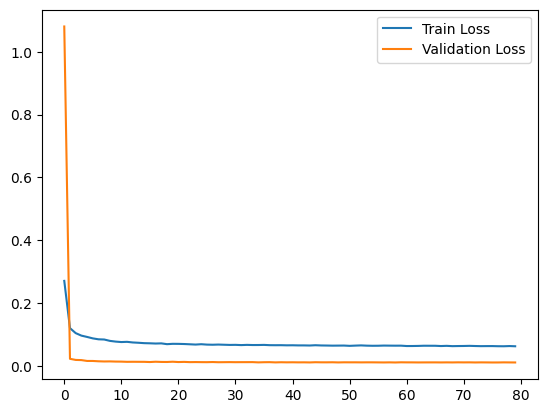

In [14]:
train_losses, val_losses = train(
    model=ddpm,
    optimizer=torch.optim.Adam(params=ddpm.parameters(), lr=1e-4),
    epochs=EPOCHS,
    device=device,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
)

# path = PATH_TO_SAVE_MODEL if PATH_TO_SAVE_MODEL is not None else "model.pth"
# 
# torch.save(ddpm.state_dict(), f"/home/debugwang/reproduce/diffusion_CIFR10/model/diffusion_lr_{2e-4}.pth")
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")

plt.legend()
plt.show()


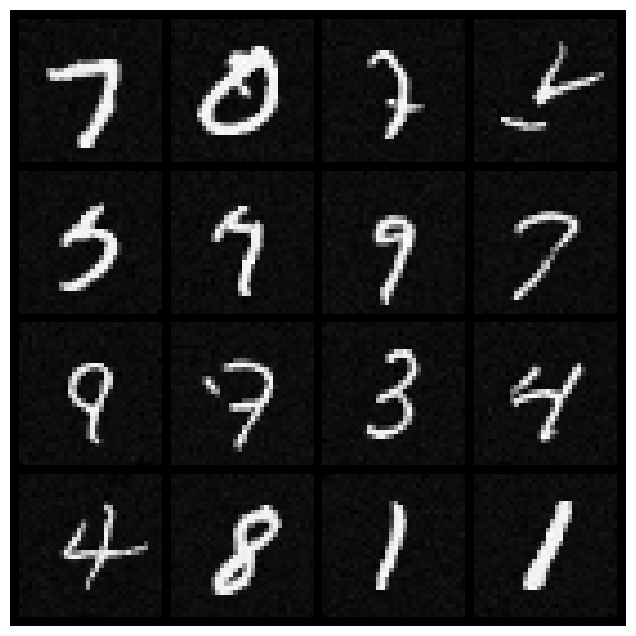

In [15]:
n_samples = 16
x_t = ddpm.sample(n_samples=n_samples, size=(1, 32,32))
show_images(x_t)


In [ ]:
torch.save(ddpm.state_dict(), 'ddpm.pth')
